In [11]:
import os
import sys
import glob
import pickle
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,balanced_accuracy_score,roc_auc_score,confusion_matrix,roc_curve
from perpetual import PerpetualBooster
from tabpfn import TabPFNClassifier
import seaborn as sns
import random
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import StratifiedKFold
from collections import Counter

In [12]:
sys.path.append("../../Utils")
from loaders import HNSCCFeatureHandler

METADATA_PATH = "../../Supplementary_Tables/ST1/RAW_HNSCC_METADATA_NEW_v10.csv"
VALID_IDS_PATH = "../../Utils/Lists/cv_ids.txt"
HOLD_IDS_PATH = '../../Utils/Lists/holdout_ids.txt'

def load_feature(path,idx,val,zscore=True,batch=True):
    f=HNSCCFeatureHandler(METADATA_PATH,VALID_IDS_PATH,HOLD_IDS_PATH)
    f.load_feature_to_dataframe(path,idx,val)
    f.normalize_zscore()
    f.merge_feature_metadata()
    if batch: f.batch_correct()
    return f
    
metrics = []
mds=load_feature("/projects/b1198/epifluidlab/ravi/0401/headneck/data/hg38_frag_filtered/*.hg38.frag.interval_mds.tsv",0,4)
ids=list(mds.institute1_ids)+list(mds.institute2_ids)+list(mds.institute3_ids)+list(mds.institute4_ids)+list(mds.institute5_ids)+list(mds.institute6_ids)

random.seed(42)
np.random.seed(42)

def prepare_train_test(data, train_ids, test_ids):
    def build_df(ids):
        feats = data.get_raw_features(data.get_subset(ids))
        meta = data.get_metadata_col("Treatment Response", data.get_subset(ids))
        pno = data.get_metadata_col("Patient Number", data.get_subset(ids))
        tov = data.get_metadata_col("Type of Visit", data.get_subset(ids))
        return pd.concat([feats, meta, pno, tov], axis=1)
    
    train_df = build_df(train_ids)
    test_df = build_df(test_ids)
    
    hold_df = pd.concat([
        data.get_raw_features(data.hold_data),
        data.get_metadata_col("Patient Number", data.hold_data),
        data.get_metadata_col("Type of Visit", data.hold_data),
        data.get_metadata_col("Treatment Response", data.hold_data)
    ], axis=1)

    return train_df, test_df, hold_df

patient_ids = np.arange(1, 69)
rkf = RepeatedKFold(n_splits=10, n_repeats=500, random_state=42)  # Generate more than needed
cv_splits = []
max_folds = 1000

for train_idx, test_idx in rkf.split(patient_ids):
    if len(cv_splits) >= max_folds:
        break

    train_patients = patient_ids[train_idx]
    test_patients = patient_ids[test_idx]

    train_ids = mds.data[mds.data["Patient Number"].isin(train_patients)].index.tolist()
    test_ids  = mds.data[mds.data["Patient Number"].isin(test_patients)].index.tolist()

    train_y = mds.data.loc[train_ids, "Treatment Response"]
    test_y  = mds.data.loc[test_ids, "Treatment Response"]

    if train_y.nunique() < 2 or test_y.nunique() < 2:
        continue

    cv_splits.append((train_ids, test_ids))

print(f"Total valid folds collected: {len(cv_splits)}")

Total valid folds collected: 1000


In [13]:
def compute_fold_metrics(y_true, y_prob, y_pred, fold=None):
    m = {
        "accuracy":      accuracy_score(y_true, y_pred),
        "f1":            f1_score(y_true, y_pred, zero_division=0),
        "precision":     precision_score(y_true, y_pred, zero_division=0),
        "recall":        recall_score(y_true, y_pred, zero_division=0),
        "balanced_ac":   balanced_accuracy_score(y_true, y_pred),
    }

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    m.update({
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    })

    if len(np.unique(y_true)) == 2:
        m["roc_auc"] = roc_auc_score(y_true, y_prob)
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        m["roc_curve"] = {
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "thresholds": thresholds.tolist()
        }

    if fold is not None:
        m["fold"] = fold
    return m

def print_classification_metrics(df):
    y_true = df["Treatment Response"] == "Responder"
    y_pred = df["Predicted Treatment Response"] == "Responder"
    y_score = df["Final Weighted Prediction"]

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "balanced_ac": balanced_accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_score)
    }
    for k, v in metrics.items():
        print(f"{k}\t{v:.3f}")

def plot_metrics(metrics, title=''):
    fpr = metrics['roc_curve']['fpr']
    tpr = metrics['roc_curve']['tpr']
    roc_auc = metrics['roc_auc']
    cm = np.array([[metrics['tn'], metrics['fp']],
                   [metrics['fn'], metrics['tp']]])
    
    plt.figure(figsize=(10, 4), dpi=1000)
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='mediumpurple', linewidth=2)
    plt.plot([0, 1], [0, 1], color='black', alpha=0.3, linestyle='--', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.text(0.55, 0.05, f'ROC AUC: {roc_auc:.2f}', fontsize=12, color='red')
    plt.xlim(-0.03, 1)
    plt.ylim(0, 1.03)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=['Non-Responder', 'Responder'],
                yticklabels=['Non-Responder', 'Responder'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.savefig(f'{title}.pdf', bbox_inches='tight')

def adjust_coefficients_mean(group):
    prob = group['mds'].mean()
    resp = group['Treatment Response'].iloc[0]
    return pd.Series({
        'Final Weighted Prediction': prob,
        'Treatment Response': resp,
        'Predicted Treatment Response': 'Responder' if prob >= 0.5 else 'Non-Responder'
    })

def adjust_coefficients_priority(group):
    visit_priority = {'Screen': 0, 'Day 0': 1, 'Adj Wk 1': 2}
    group = group.copy()
    group['Visit Priority'] = group['Type of Visit'].map(visit_priority)
    most_recent = group.loc[group['Visit Priority'].idxmax()]

    prob = most_recent['mds']
    resp = most_recent['Treatment Response']
    return pd.Series({
        'Final Weighted Prediction': prob,
        'Treatment Response': resp,
        'Predicted Treatment Response': 'Responder' if prob >= 0.5 else 'Non-Responder'
    })

def plot_roc(df, title, fname):
    fpr, tpr, _ = roc_curve(df['Treatment Response'] == 'Responder', df['Final Weighted Prediction'])
    auc_score = roc_auc_score(df['Treatment Response'] == 'Responder', df['Final Weighted Prediction'])
    plt.figure(figsize=(2, 2), dpi=300)
    plt.plot(fpr, tpr, color="mediumpurple")
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.3)
    plt.text(0.4, 0.05, f"ROC AUC: {auc_score:.2f}", fontsize=6)
    plt.title(title, fontsize=6)
    plt.xlabel("False Positive Rate", fontsize=6)
    plt.ylabel("True Positive Rate", fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

def plot_cm(df, title, fname):
    cm = confusion_matrix(df['Treatment Response'], df['Predicted Treatment Response'], labels=['Responder', 'Non-Responder'])
    plt.figure(figsize=(2.5, 2.5), dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=['Responder', 'Non-Responder'], yticklabels=['Responder', 'Non-Responder'],
                annot_kws={"fontsize": 6})
    plt.title(title, fontsize=6)
    plt.xlabel('Predicted Label', fontsize=6)
    plt.ylabel('True Label', fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

In [14]:
def train_model(
    df, response_col="Treatment Response",
    k_features=6,
    base_model_cls=None, base_model_kwargs=None,
    random_state=42
):
    from sklearn.decomposition import TruncatedSVD
    from sklearn.utils import resample
    from sklearn.model_selection import StratifiedKFold

    class_counts = df[response_col].value_counts()
    minority_class = class_counts.idxmin()
    majority_class = class_counts.idxmax()

    df_minority = df[df[response_col] == minority_class]
    df_majority = df[df[response_col] == majority_class]

    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=random_state
    )

    df_balanced = pd.concat([df_minority, df_majority_downsampled]).sample(frac=1, random_state=random_state)

    X = df_balanced.drop(columns=[response_col, "Patient Number", "Type of Visit"])
    y = (df_balanced[response_col] == "Responder").astype(int).to_numpy()

    final_svd = TruncatedSVD(n_components=k_features, random_state=random_state).fit(X)
    final_model = base_model_cls(**(base_model_kwargs or {})).fit(final_svd.transform(X), y)

    return final_svd, final_model

def eval_model(
    df_test, svd, model, name,
    response_col="Treatment Response"
):
    X = df_test.drop(columns=[response_col, "Patient Number", "Type of Visit"])
    X_red = svd.transform(X)

    visits = ["Screen", "Day 0", "Adj Wk 1", "Overall"]
    probs = {}

    for visit in visits:
        mask = slice(None) if visit == "Overall" else (df_test["Type of Visit"] == visit)
        fold = "Overall" if visit == "Overall" else visit.replace(" ", "_")
        Xv = X_red[df_test.index.get_indexer(df_test.index[mask])]
        yv = (df_test.loc[mask, response_col] == "Responder").astype(int)
        p = model.predict_proba(Xv)[:, 1]
        yp = (p >= 0.5).astype(int)
        metrics.append(compute_fold_metrics(yv, p, yp, fold=f"MDS_{name}_{fold}"))
        probs[visit] = pd.Series(p, index=df_test.index[mask])
    test_eval = pd.DataFrame(probs["Overall"], columns=["mds"])
    test_eval_w_information = pd.concat([test_eval, df_test['Treatment Response'], df_test['Patient Number'], df_test['Type of Visit']], axis=1).groupby('Patient Number').apply(adjust_coefficients_priority)
    metrics.append(compute_fold_metrics(test_eval_w_information['Treatment Response']=="Responder", test_eval_w_information["Final Weighted Prediction"], test_eval_w_information['Predicted Treatment Response']=="Responder", fold=f"MDS_{name}_Patient")) 


In [15]:
for i, (train_ids, test_ids) in tqdm(enumerate(cv_splits)):
    mds_train, mds_test, _ = prepare_train_test(mds, train_ids, test_ids)
    assert set(mds_train.index).isdisjoint(mds_test.index), "Train and test sets overlap!"
    mds_svd, mds_m = train_model(
        mds_train,
        k_features=6,
        base_model_cls=TabPFNClassifier,
        random_state=42
    )
    eval_model(mds_test, mds_svd, mds_m, f"Cross_Validation_{i // 10},{i % 10}")

1000it [18:49,  1.13s/it]


In [16]:
from itertools import combinations

institute_ids = [
    list(mds.institute1_ids),
    list(mds.institute2_ids),
    list(mds.institute3_ids),
    list(mds.institute4_ids),
    list(mds.institute5_ids),
    list(mds.institute6_ids),
]

for test_combo in combinations(range(6), 1):
    print(test_combo)
    train_ids = sum([institute_ids[i] for i in range(6) if i not in test_combo], [])
    test_ids  = sum([institute_ids[i] for i in test_combo], [])
    mds_train, mds_test, _ = prepare_train_test(mds, train_ids, test_ids)
    assert set(mds_train.index).isdisjoint(mds_test.index), "Train and test sets overlap!"

    mds_svd, mds_m = train_model(
        mds_train,
        k_features=6,
        base_model_cls=TabPFNClassifier,
        random_state=42
    )
    eval_model(mds_test, mds_svd, mds_m, f"Institute_Hold_Out_{test_combo[0]}")

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)


In [17]:
def generate_random_lists(num_lists, seed=42):
    random.seed(seed)
    return [random.sample(range(1, 69), 10) for _ in range(num_lists)]

train_ids = (
    list(mds.institute1_idsa) +
    list(mds.institute2_idsa) +
    list(mds.institute3_idsa) +
    list(mds.institute4_idsa) +
    list(mds.institute5_idsa) +
    list(mds.institute6_idsa)
)

test_ids = []

lists = generate_random_lists(100)
for i in tqdm(range(100), desc="Repeats"):
    patient_list = lists[i]

    def load_feature(path, idx, val, zscore=True, batch=True):
        f = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH, HOLD_IDS_PATH)
        f.load_feature_to_dataframe(path, idx, val)
        f.normalize_zscore()
        f.merge_feature_metadata()
        some_data = pd.concat([f.data, f.hold_data])
        f.hold_data = some_data[some_data["Patient Number"].isin(patient_list)]
        f.data      = some_data[~some_data["Patient Number"].isin(patient_list)]
        if batch: f.batch_correct()
        return f

    mds = load_feature("/projects/b1198/epifluidlab/ravi/0401/headneck/data/hg38_frag_filtered/*.hg38.frag.interval_mds.tsv", 0, 4)

    mds_train, _, mds_hold = prepare_train_test(mds, train_ids, test_ids)
    assert set(mds_train.index).isdisjoint(mds_hold.index), "Train and hold sets overlap!"
    
    mds_svd, mds_m = train_model(
        mds_train,
        k_features=6,
        base_model_cls=TabPFNClassifier,
        random_state=42
    )
    eval_model(mds_hold, mds_svd, mds_m, f"Pre_Hold_Out_{i}")

Repeats: 100%|██████████| 100/100 [05:47<00:00,  3.47s/it]


In [18]:
pd.DataFrame(metrics).to_csv('ST5.csv')

In [19]:
import fnmatch
def plot_metrics_by_glob(metrics_list, glob_pattern, title=''):
    filtered_metrics = [m for m in metrics_list if 'fold' in m and fnmatch.fnmatch(m['fold'], glob_pattern)]
    if not filtered_metrics:
        print(f"No metrics found matching pattern: {glob_pattern}")
        return
    print(f"Found {len(filtered_metrics)} metrics matching pattern: {glob_pattern}")
    df_filtered = pd.DataFrame(filtered_metrics)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
    ax1 = axes[0]
    all_aucs = []
    for _, row in df_filtered.iterrows():
        if 'roc_auc' in row and not pd.isna(row['roc_auc']) and isinstance(row['roc_auc'], (int, float)):
            all_aucs.append(row['roc_auc'])
    mean_fpr = np.linspace(0, 1, 100)
    all_interp = []
    sens_at_90spec = []
    sens_at_95spec = []
    for _, row in df_filtered.iterrows():
        if ('roc_curve' in row and row['roc_curve'] is not None and 
            isinstance(row['roc_curve'], dict) and 
            'fpr' in row['roc_curve'] and 'tpr' in row['roc_curve']):
            fpr = np.array(row['roc_curve']['fpr'])
            tpr = np.array(row['roc_curve']['tpr'])
            if fpr[0] != 0:
                fpr = np.concatenate([[0], fpr])
                tpr = np.concatenate([[0], tpr])
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            all_interp.append(interp_tpr)
            spec = 1 - fpr
            mask_90 = fpr <= 0.10
            mask_95 = fpr <= 0.05
            if np.any(mask_90):
                sens_at_90spec.append(np.max(tpr[mask_90]))
            if np.any(mask_95):
                sens_at_95spec.append(np.max(tpr[mask_95]))
    print(len(all_interp))
    if all_interp:
        all_interp = np.array(all_interp)
        mean_tpr = np.mean(all_interp, axis=0)
        mean_tpr[0] = 0.0
        mean_tpr[-1] = 1.0
        std_tpr = np.std(all_interp, axis=0)
        tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
        tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
        mean_auc = np.mean(all_aucs) if all_aucs else 0
        std_auc = np.std(all_aucs) if all_aucs else 0
        print(f"{title} AUC STD_{std_auc:.3f}")
        ax1.plot(mean_fpr, mean_tpr, linewidth=2, color='mediumpurple',
                 label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
        ax1.fill_between(mean_fpr, tpr_lower, tpr_upper, color='mediumpurple', alpha=0.2)
    if sens_at_90spec:
        mean_sens90 = np.mean(sens_at_90spec)
        std_sens90 = np.std(sens_at_90spec)
        print(f"Sensitivity at 90% specificity: {mean_sens90:.3f} ± {std_sens90:.3f}")
    else:
        print("No data for sensitivity at 90% specificity.")
    if sens_at_95spec:
        mean_sens95 = np.mean(sens_at_95spec)
        std_sens95 = np.std(sens_at_95spec)
        print(f"Sensitivity at 95% specificity: {mean_sens95:.3f} ± {std_sens95:.3f}")
    else:
        print("No data for sensitivity at 95% specificity.")
    ax1.plot([0, 1], [0, 1], linestyle='--', alpha=0.5, color='gray')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{title}\nMean ± SD ROC Curve')
    ax1.legend()
    percent_cms = []
    for _, row in df_filtered.iterrows():
        if all(col in row for col in ['tn', 'fp', 'fn', 'tp']):
            cm = np.array([[row['tn'], row['fp']],
                          [row['fn'], row['tp']]], dtype=float)
            row_sums = cm.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1
            cm_norm = (cm / row_sums) * 100
            percent_cms.append(cm_norm)
    if percent_cms:
        percent_cms = np.array(percent_cms)
        mean_cm = np.nanmean(percent_cms, axis=0)
        std_cm = np.nanstd(percent_cms, axis=0)
        labels = np.empty(mean_cm.shape, dtype=object)
        for i in range(2):
            for j in range(2):
                labels[i, j] = f"{mean_cm[i, j]:.1f}%\n±{std_cm[i, j]:.1f}%"
        sns.heatmap(
            mean_cm,
            annot=labels,
            fmt='',
            cmap='Purples',
            cbar=False,
            xticklabels=['Non-Responder', 'Responder'],
            yticklabels=['Non-Responder', 'Responder'],
            ax=axes[1]
        )
        axes[1].set_ylabel('True Label')
        axes[1].set_xlabel('Predicted Label')
        axes[1].set_title(f'{title}\nMean ± SD Confusion Matrix (%)')
    else:
        axes[1].text(0.5, 0.5, 'No confusion matrix data available', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title(f'{title} Confusion Matrix')
    fig.tight_layout()
    clean_title = title.replace(' ', '_').replace('*', 'star').replace('?', 'q')
    fig.savefig(f'{clean_title}.pdf')
    plt.show()
    plt.close(fig)

Found 1000 metrics matching pattern: MDS_Cross_Validation_*_Screen
993
Cross Validation Screen AUC STD_0.093
Sensitivity at 90% specificity: 0.930 ± 0.185
Sensitivity at 95% specificity: 0.930 ± 0.185


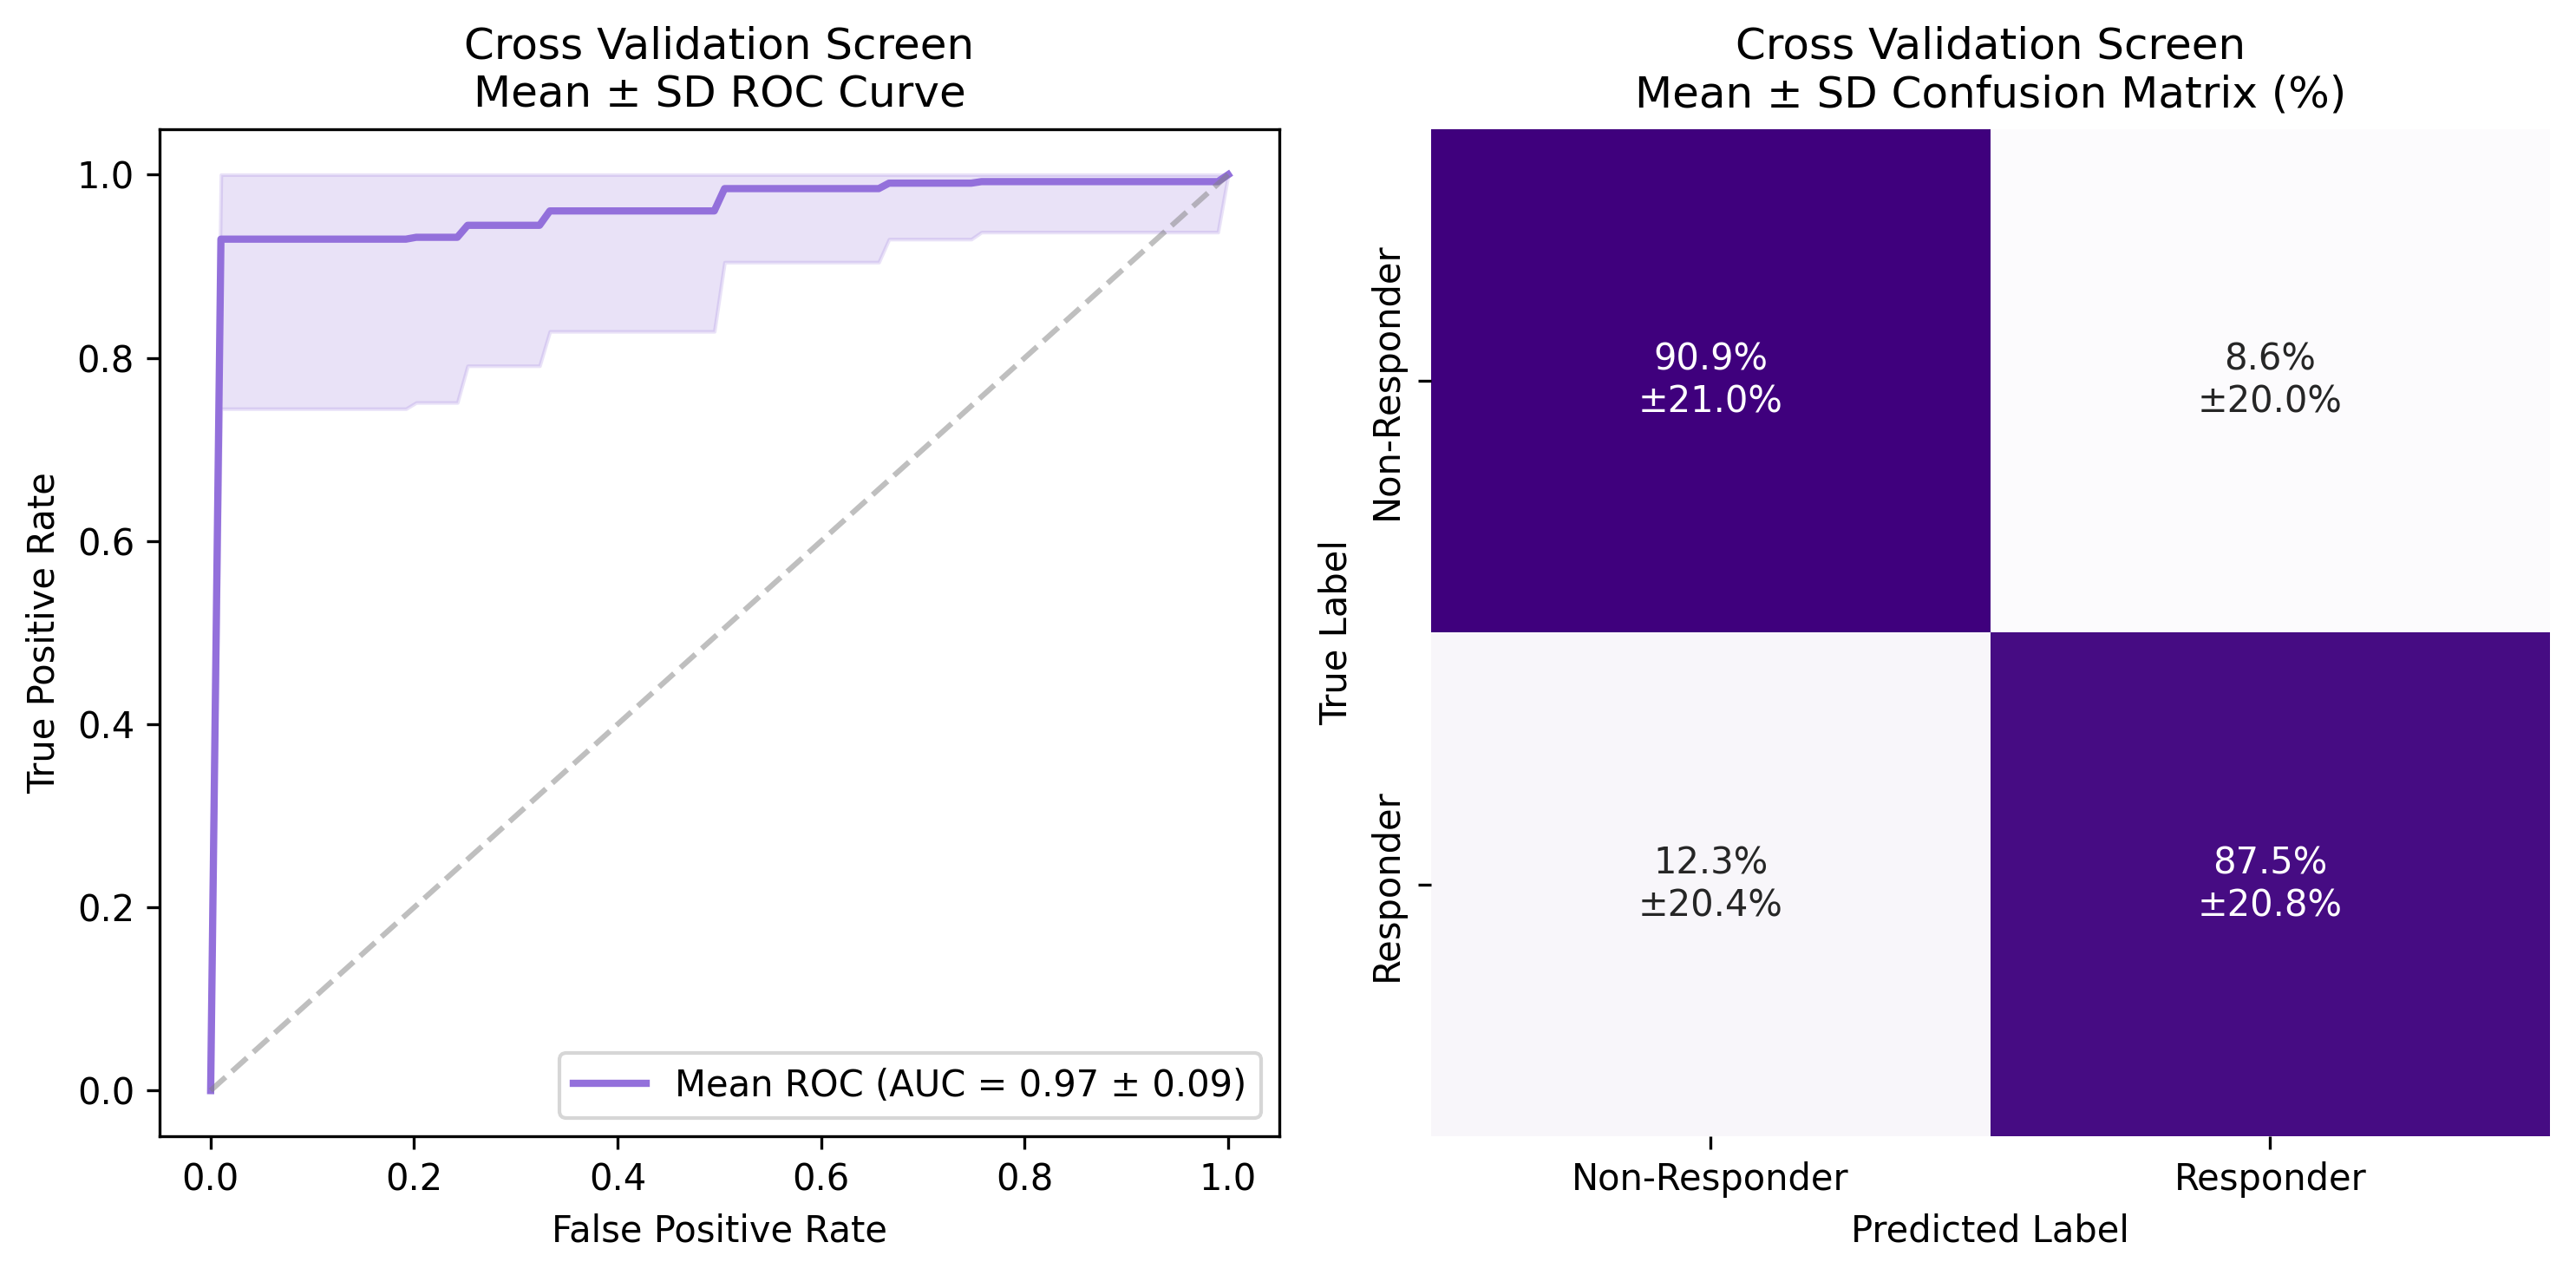

Found 1000 metrics matching pattern: MDS_Cross_Validation_*_Day_0
977
Cross Validation Day 0 AUC STD_0.123
Sensitivity at 90% specificity: 0.893 ± 0.229
Sensitivity at 95% specificity: 0.893 ± 0.229


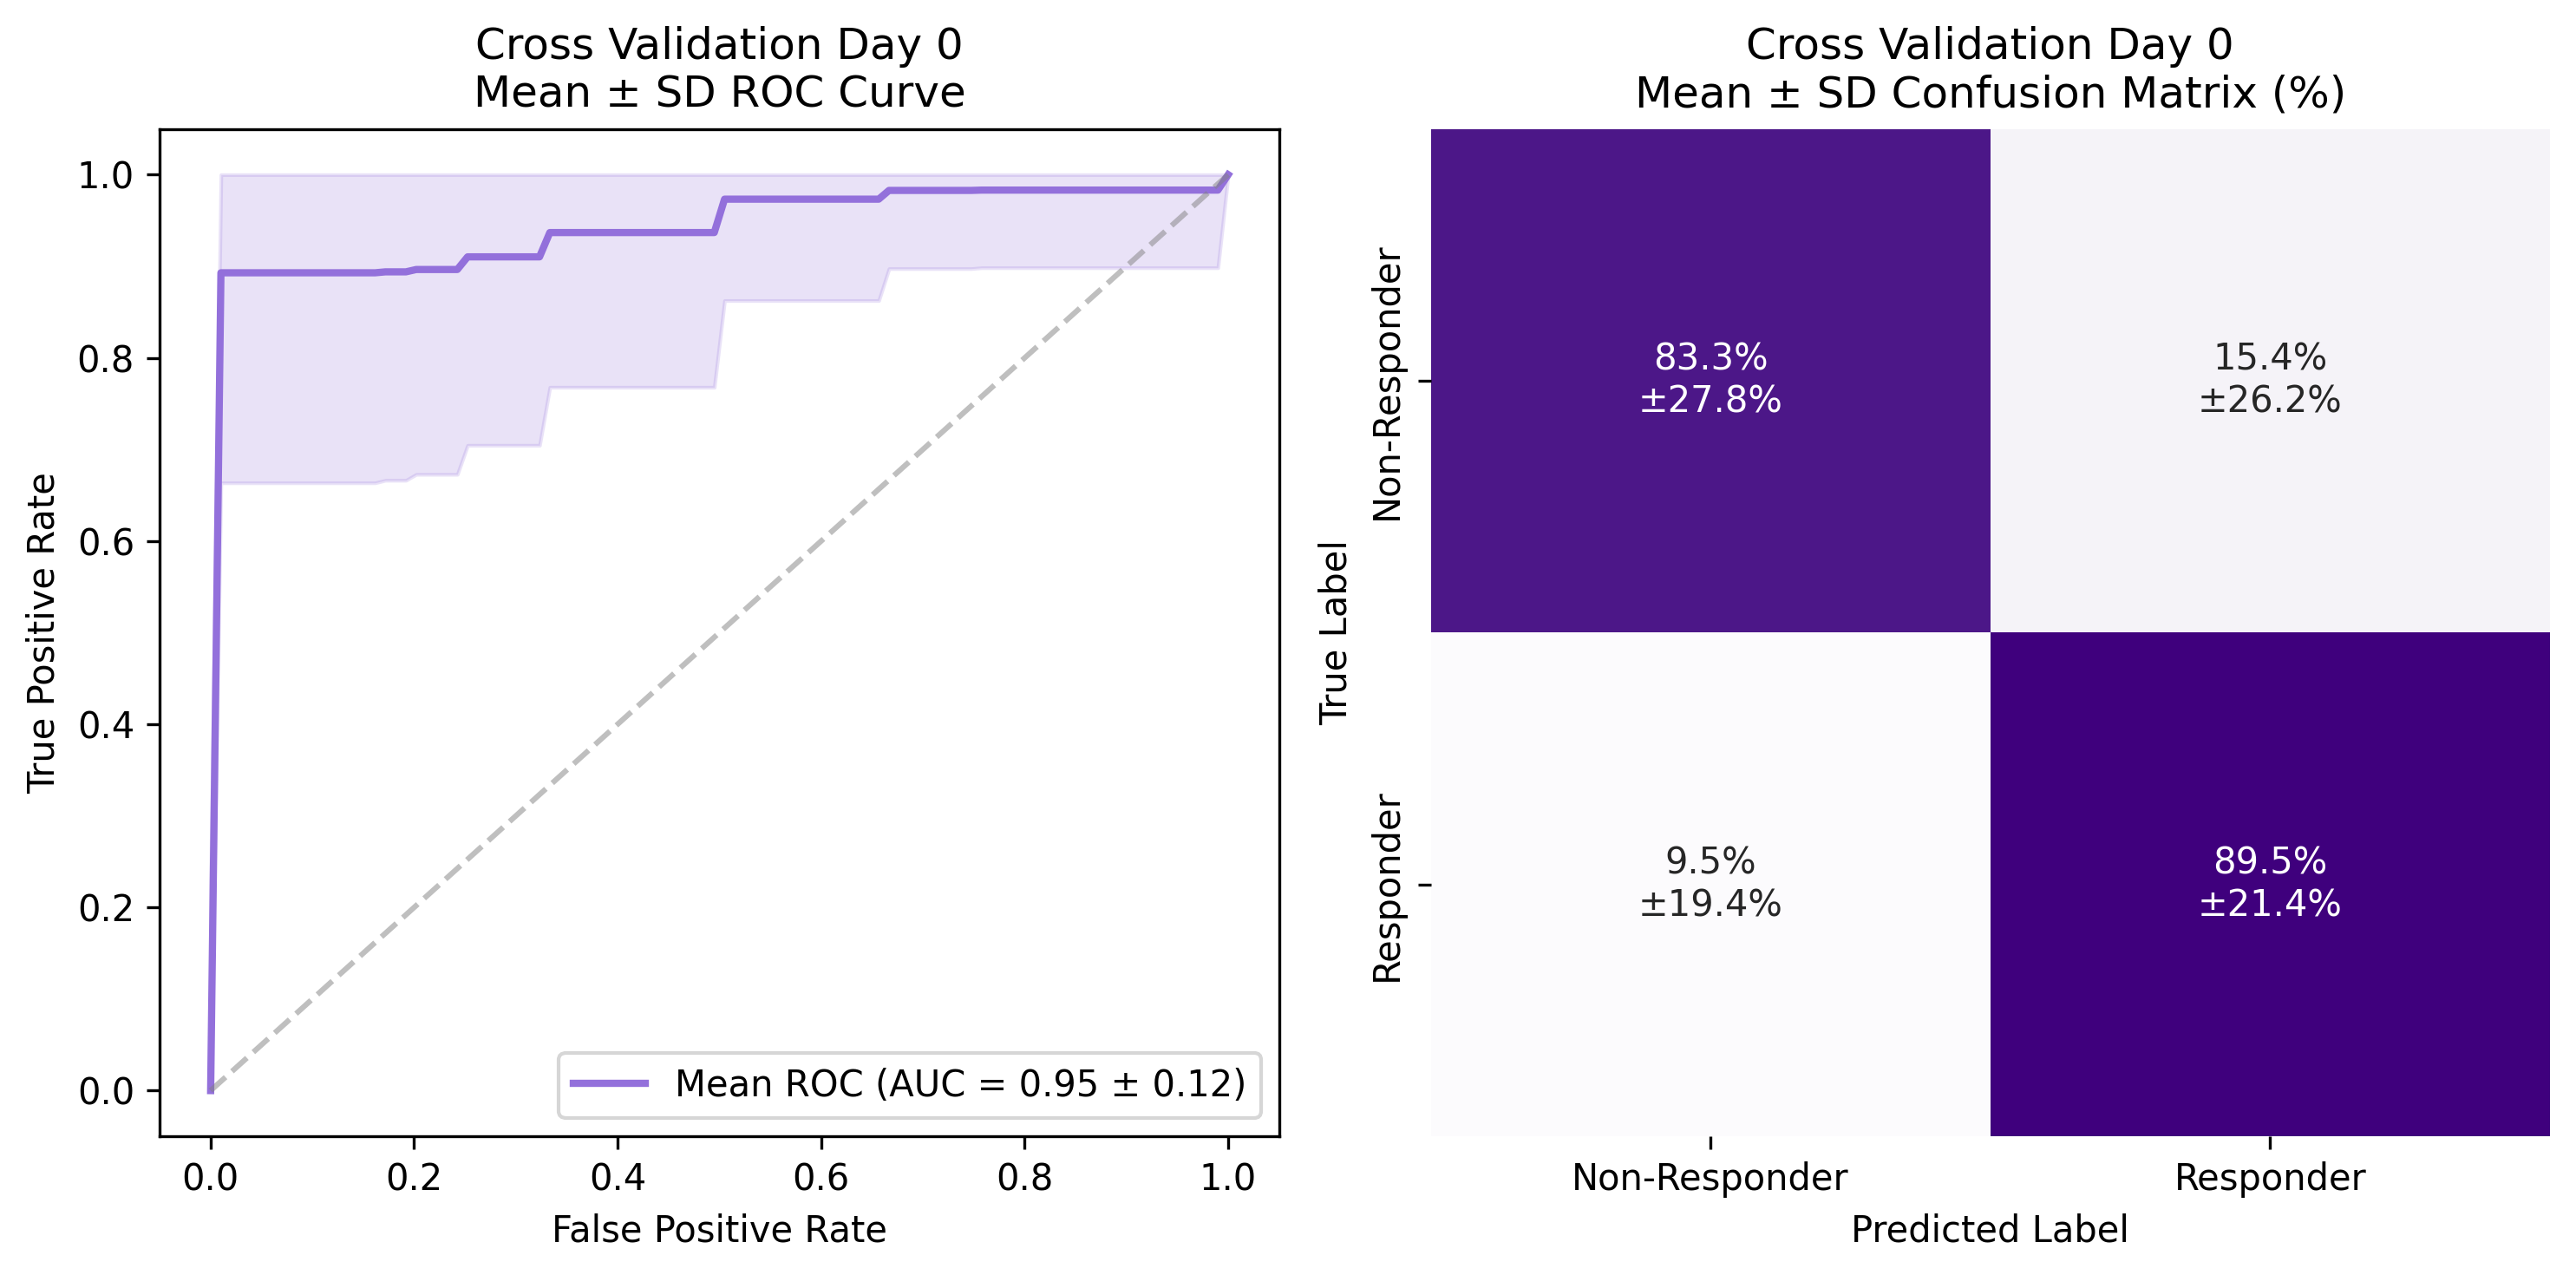

Found 1000 metrics matching pattern: MDS_Cross_Validation_*_Adj_Wk_1
924
Cross Validation Adj Wk 1 AUC STD_0.042
Sensitivity at 90% specificity: 0.988 ± 0.073
Sensitivity at 95% specificity: 0.988 ± 0.073


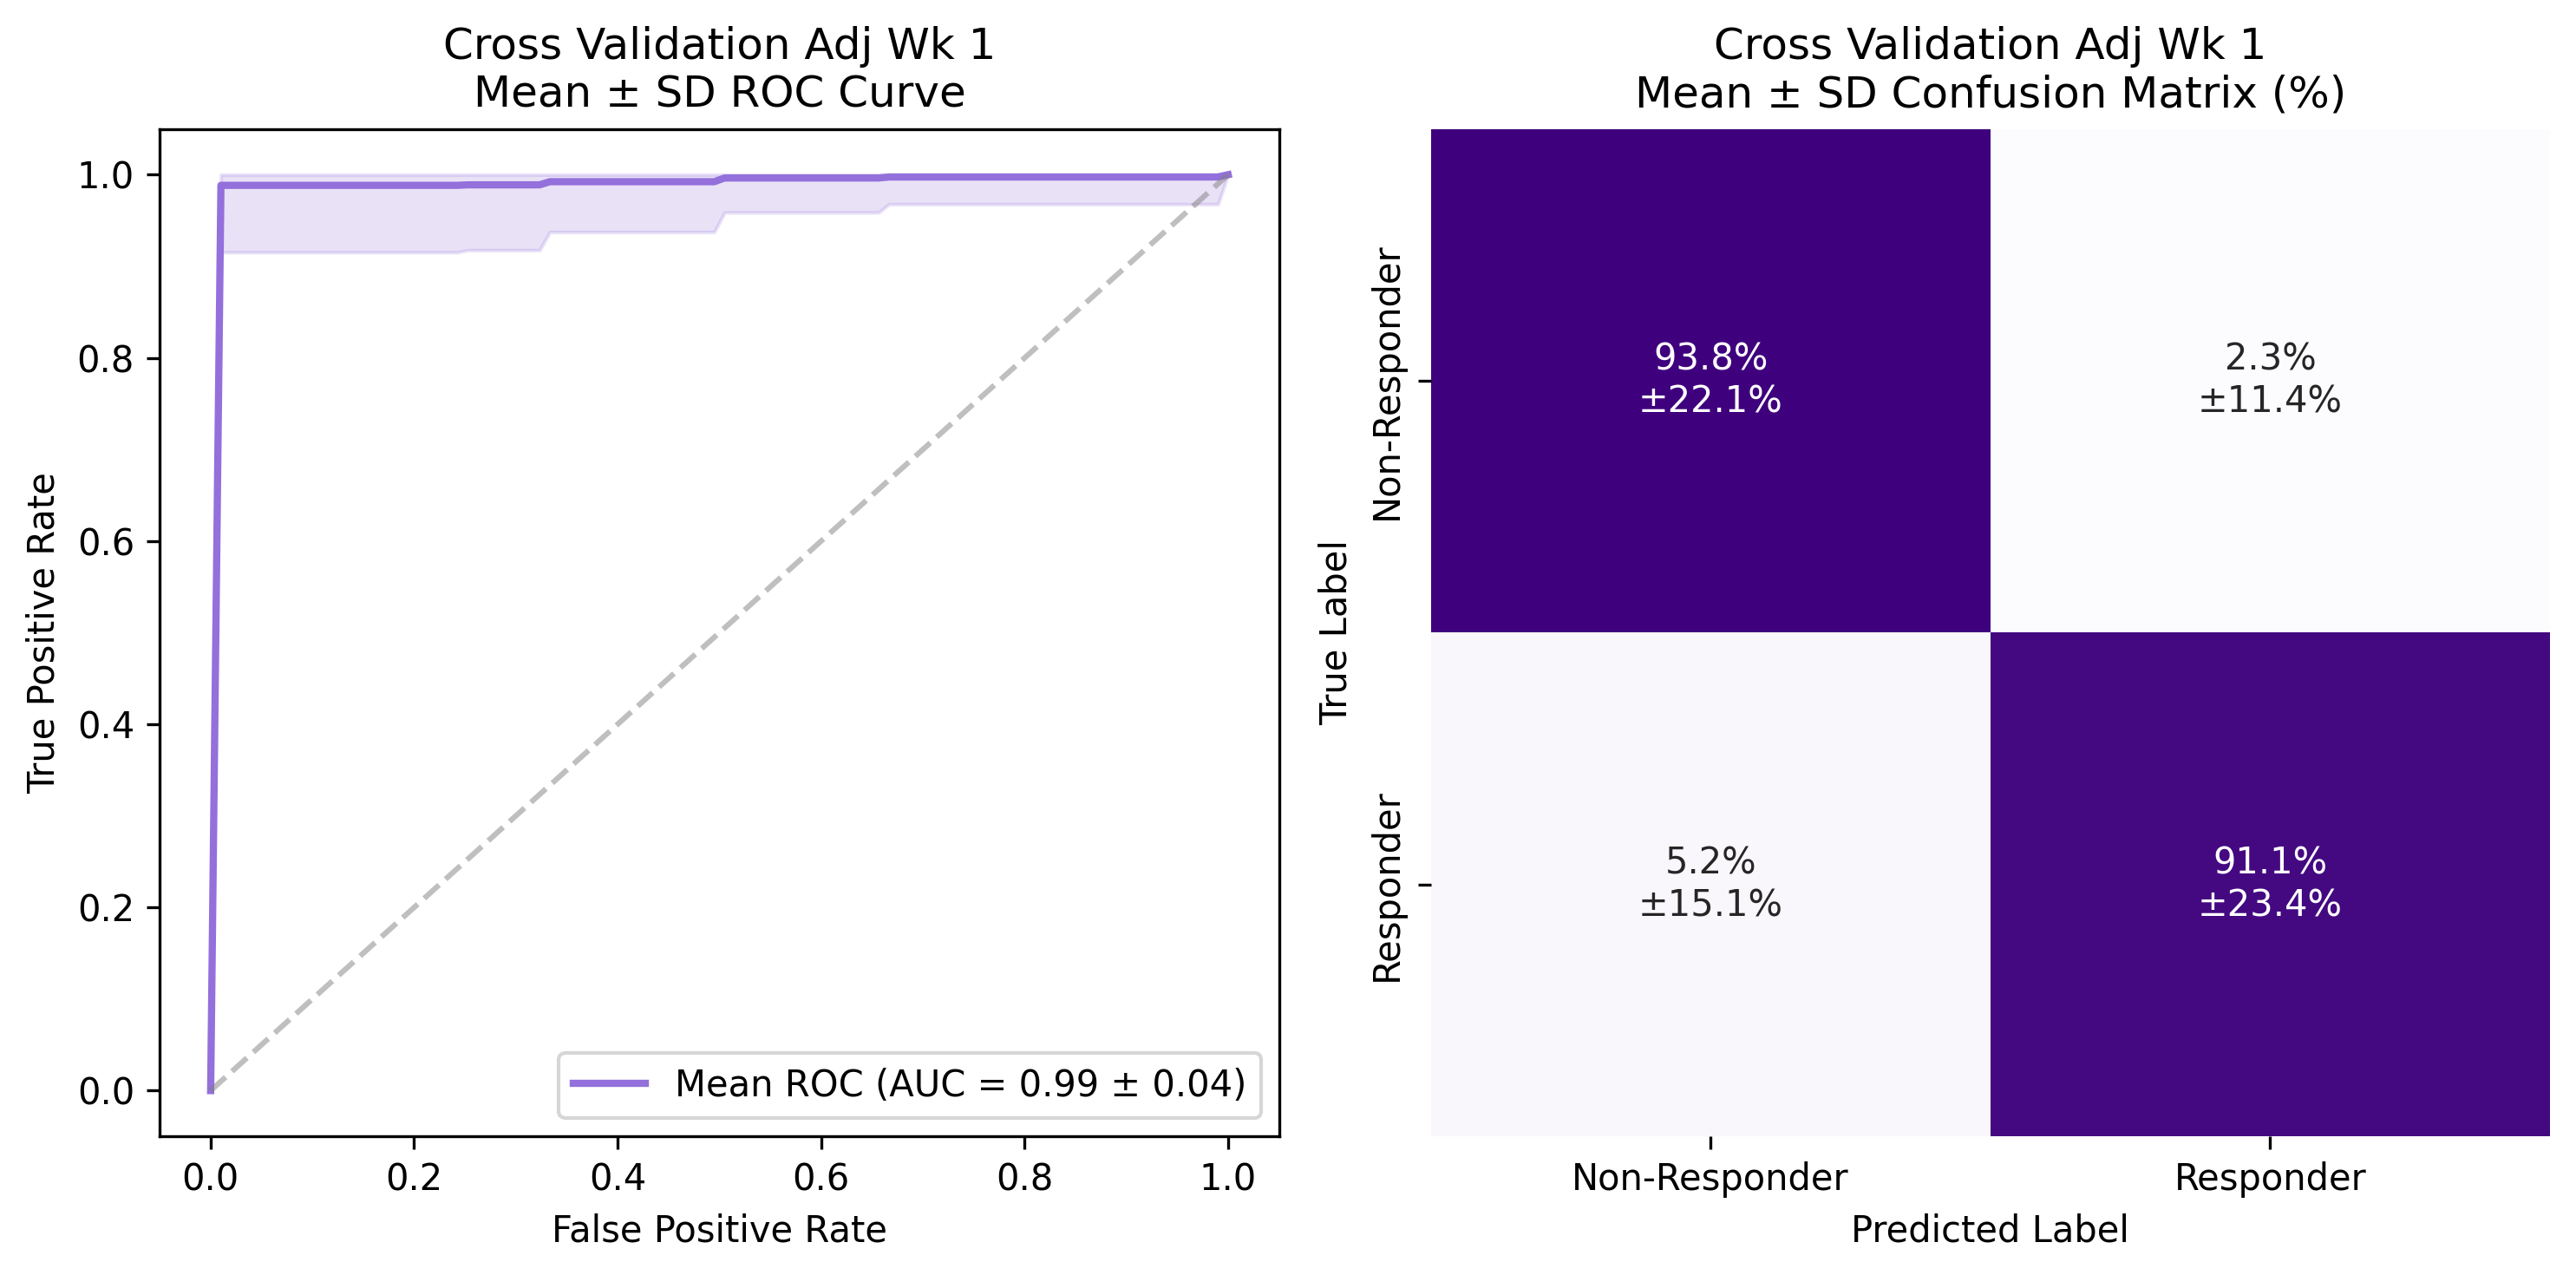

Found 1000 metrics matching pattern: MDS_Cross_Validation_*_Overall
1000
Cross Validation Overall AUC STD_0.052
Sensitivity at 90% specificity: 0.896 ± 0.175
Sensitivity at 95% specificity: 0.874 ± 0.199


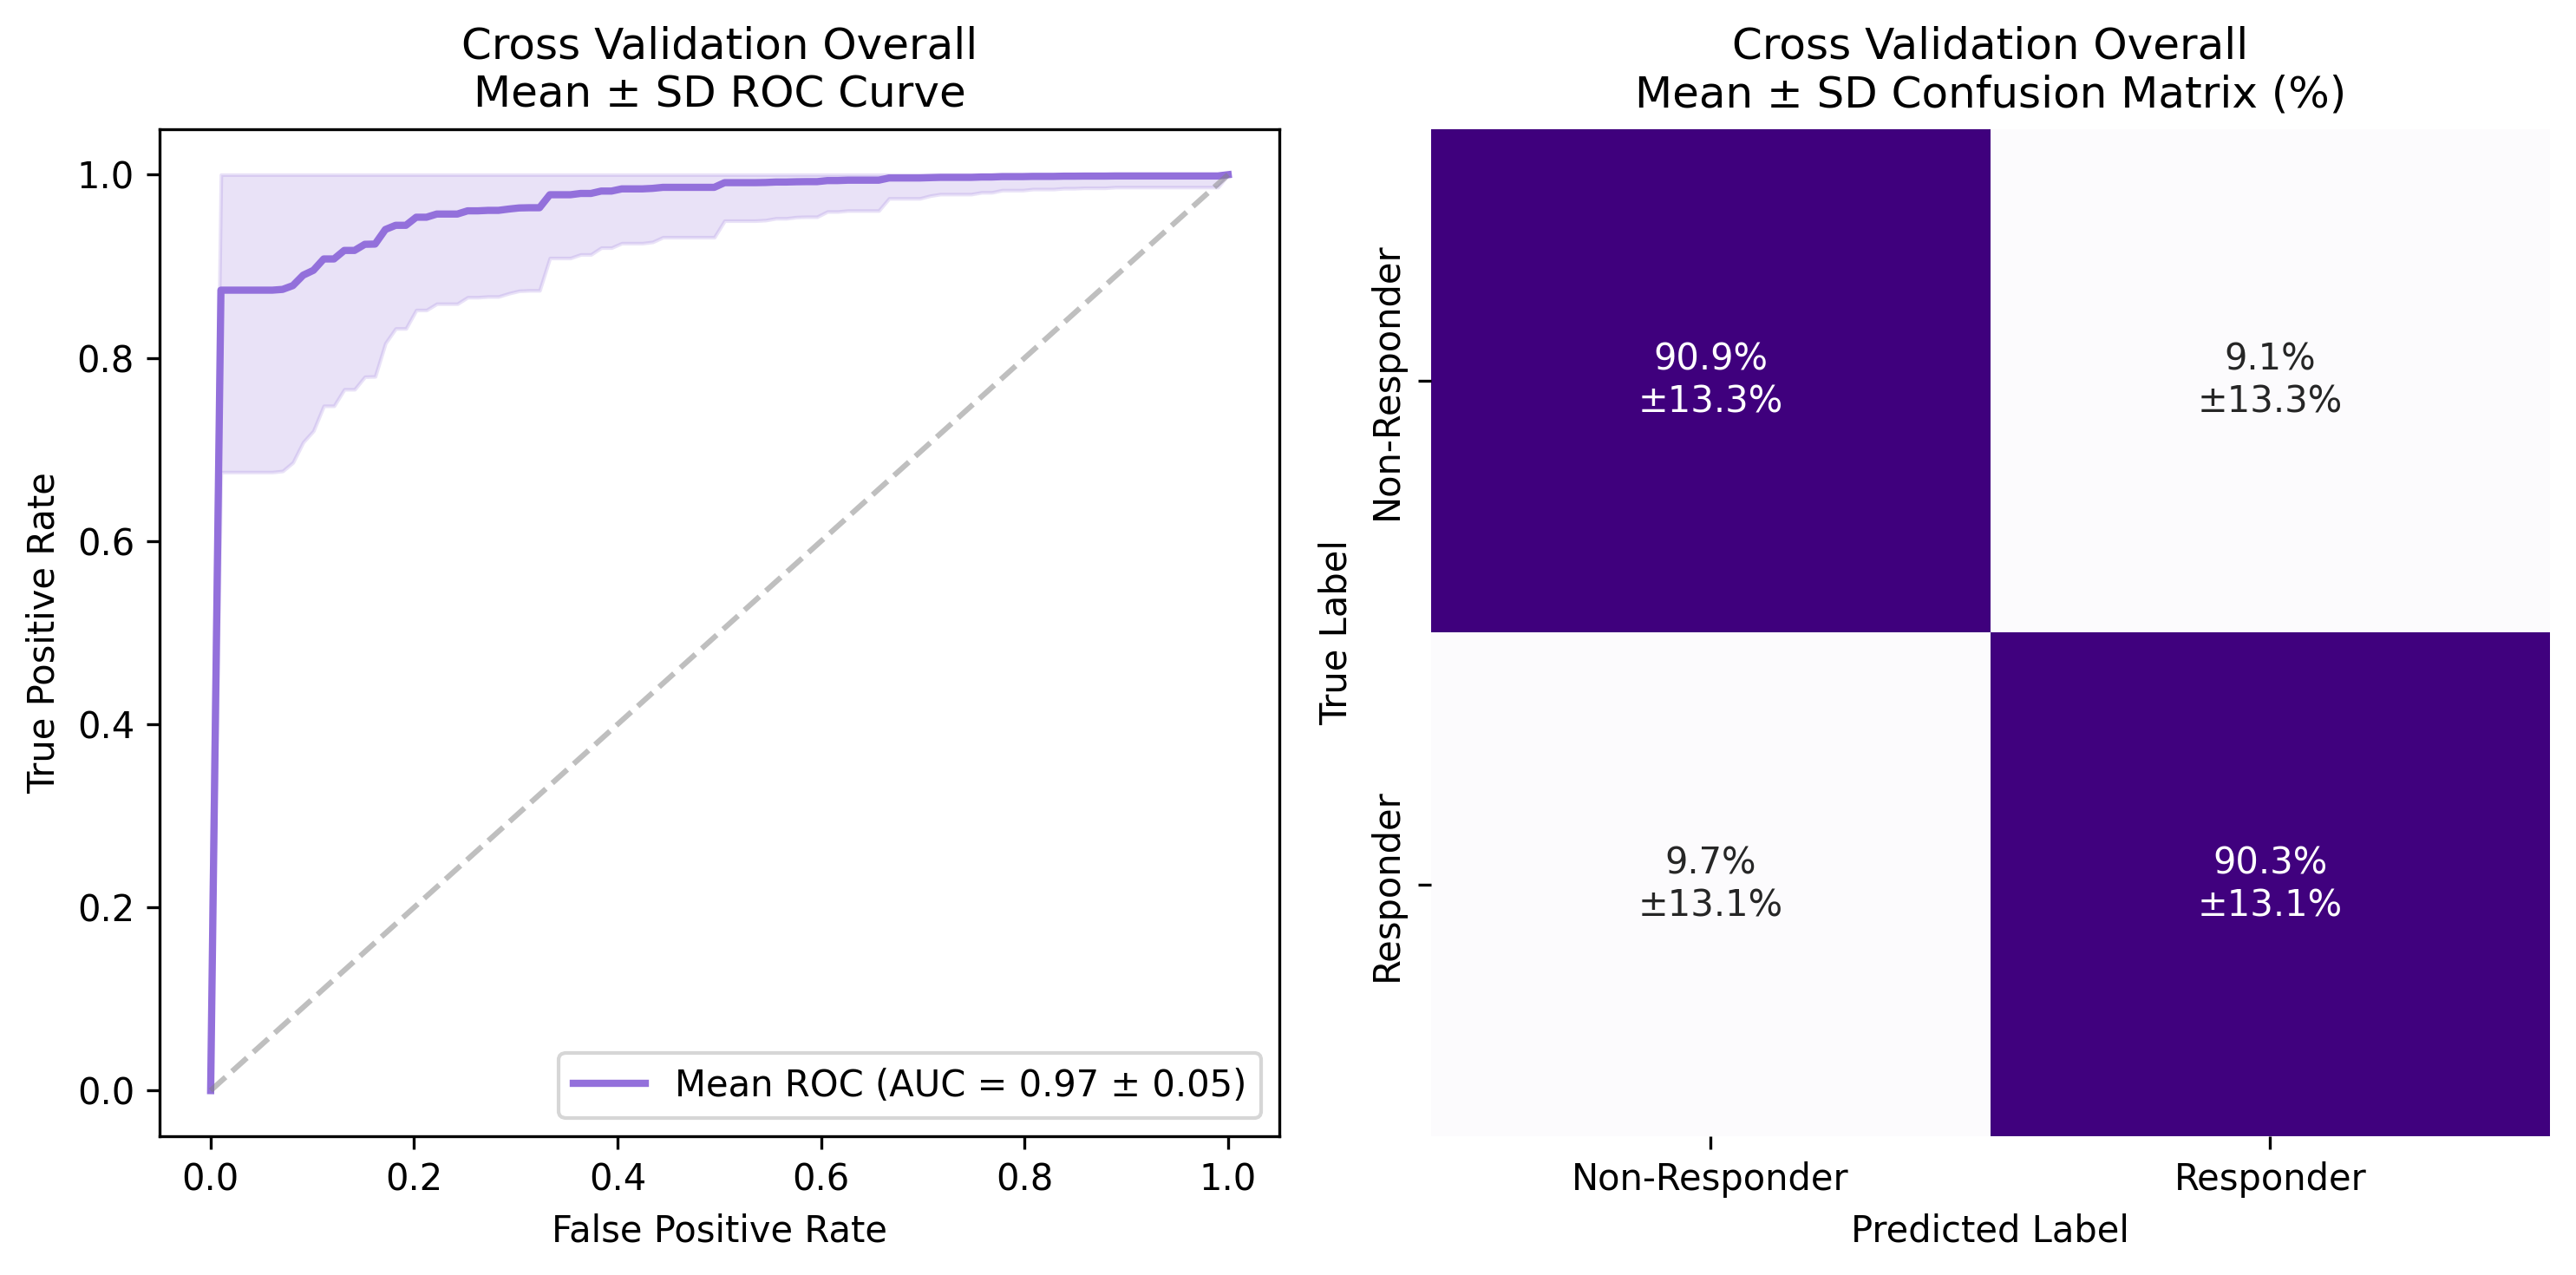

Found 1000 metrics matching pattern: MDS_Cross_Validation_*_Patient
1000
Cross Validation Patient Level AUC STD_0.045
Sensitivity at 90% specificity: 0.976 ± 0.101
Sensitivity at 95% specificity: 0.976 ± 0.101


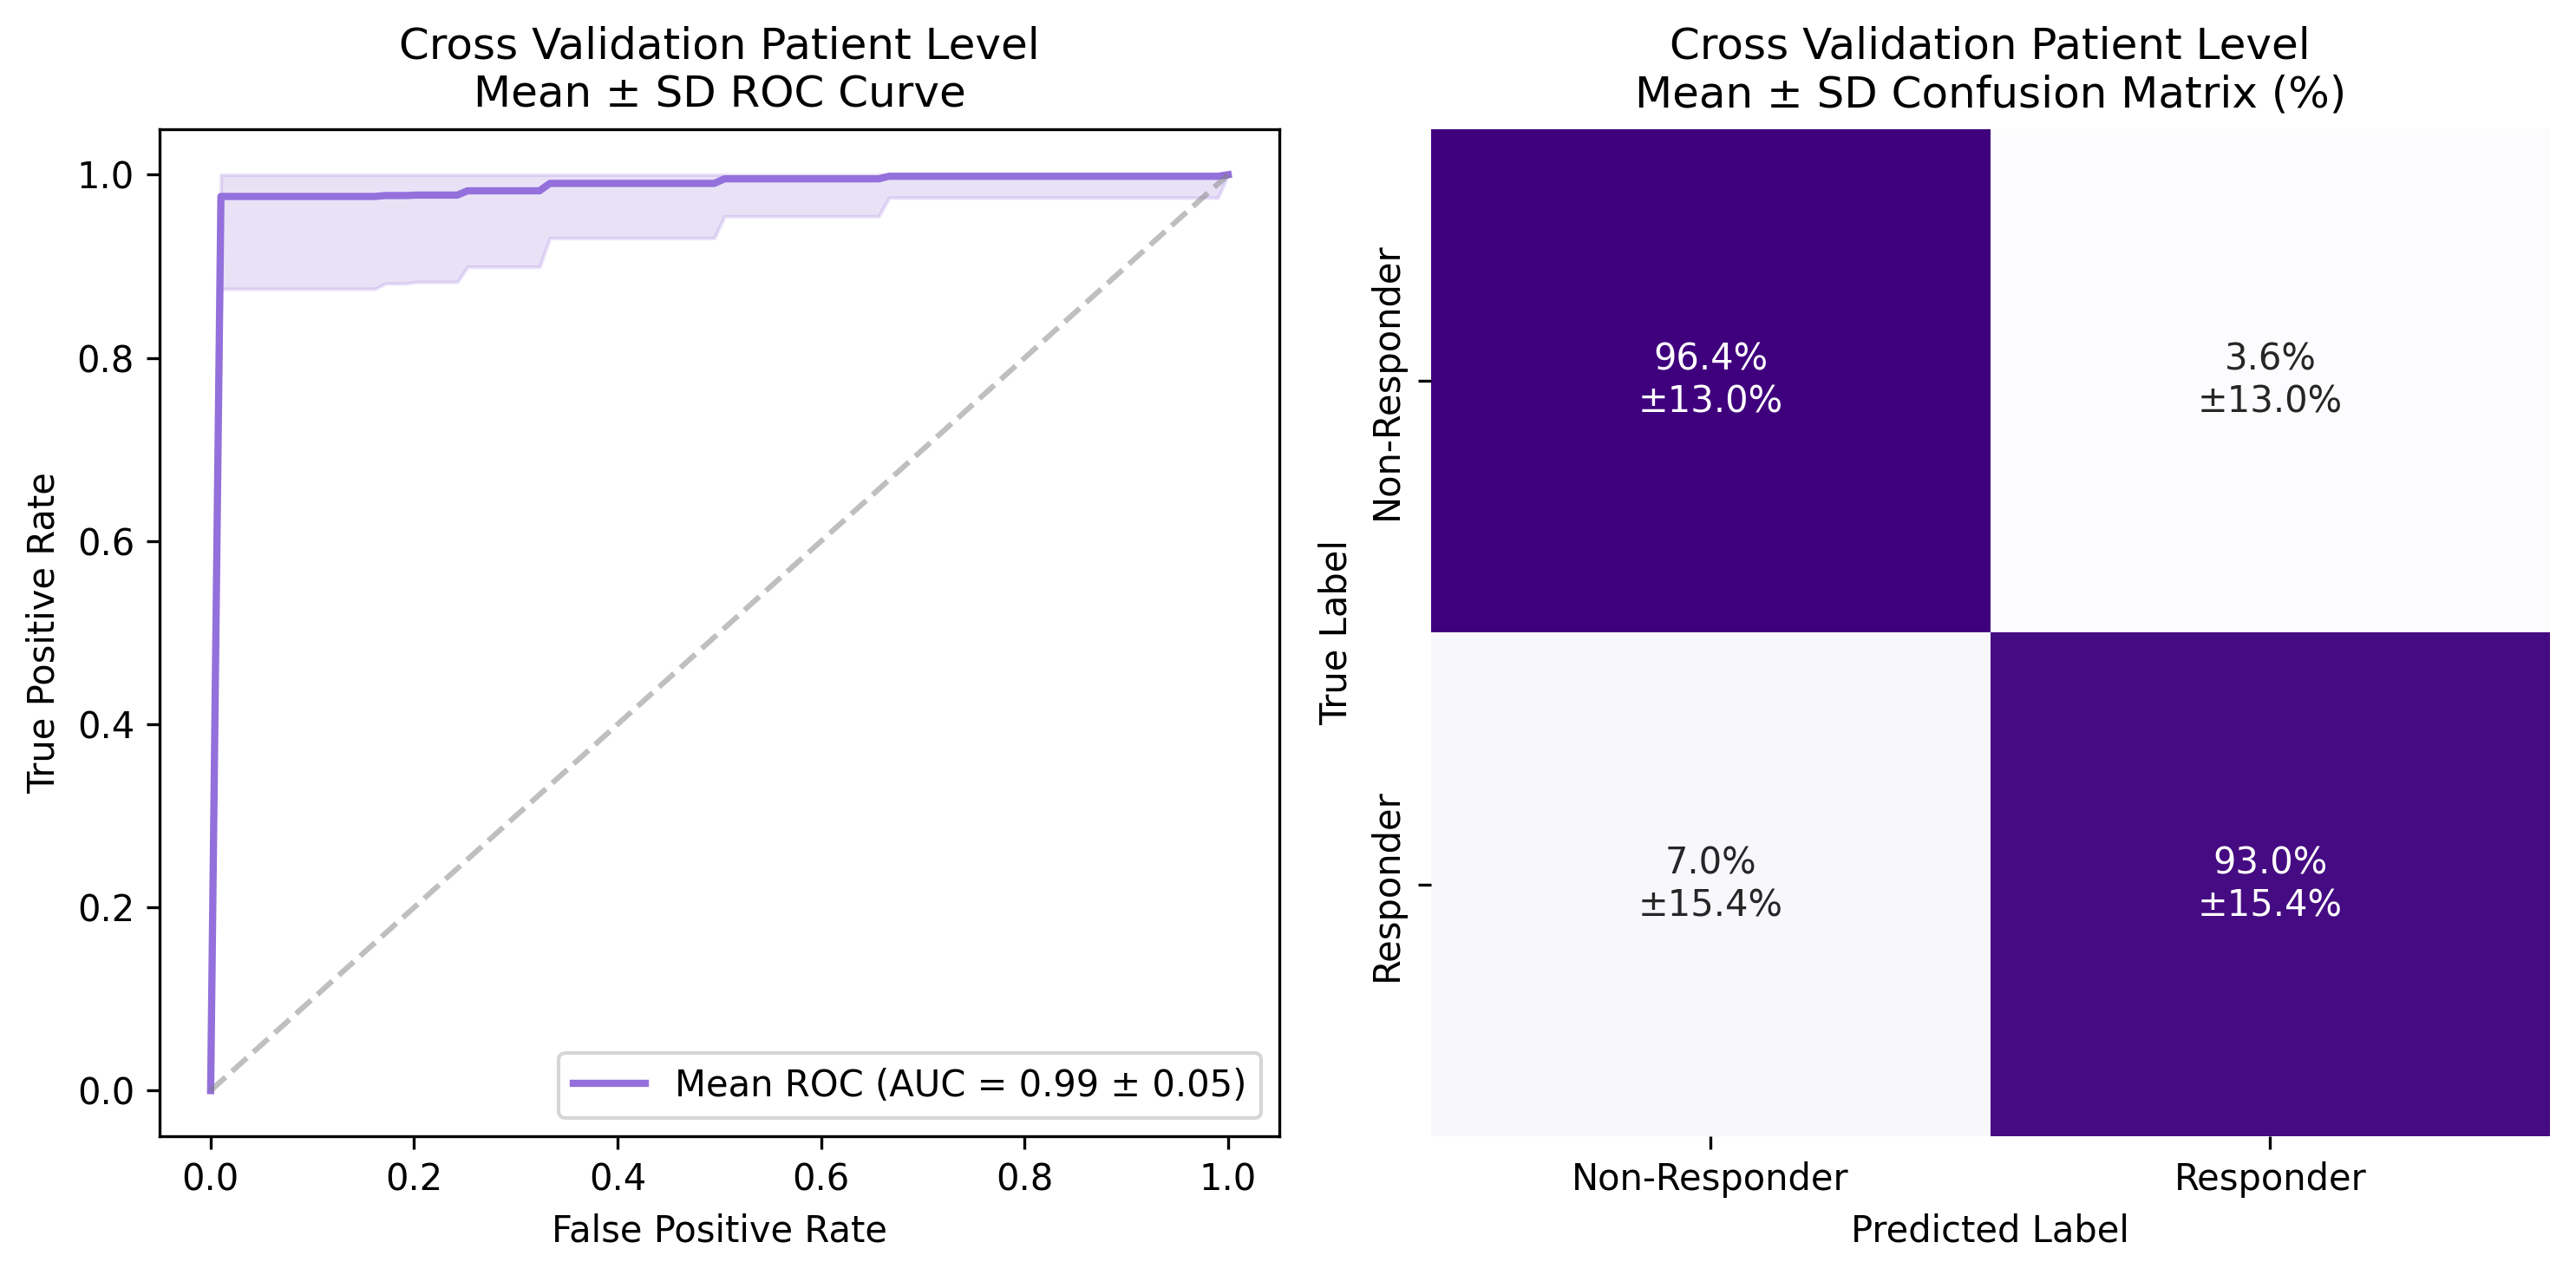

Found 6 metrics matching pattern: MDS_Institute_Hold_Out_*_Screen
6
Institute Hold Out Screen AUC STD_0.148
Sensitivity at 90% specificity: 0.565 ± 0.377
Sensitivity at 95% specificity: 0.542 ± 0.394


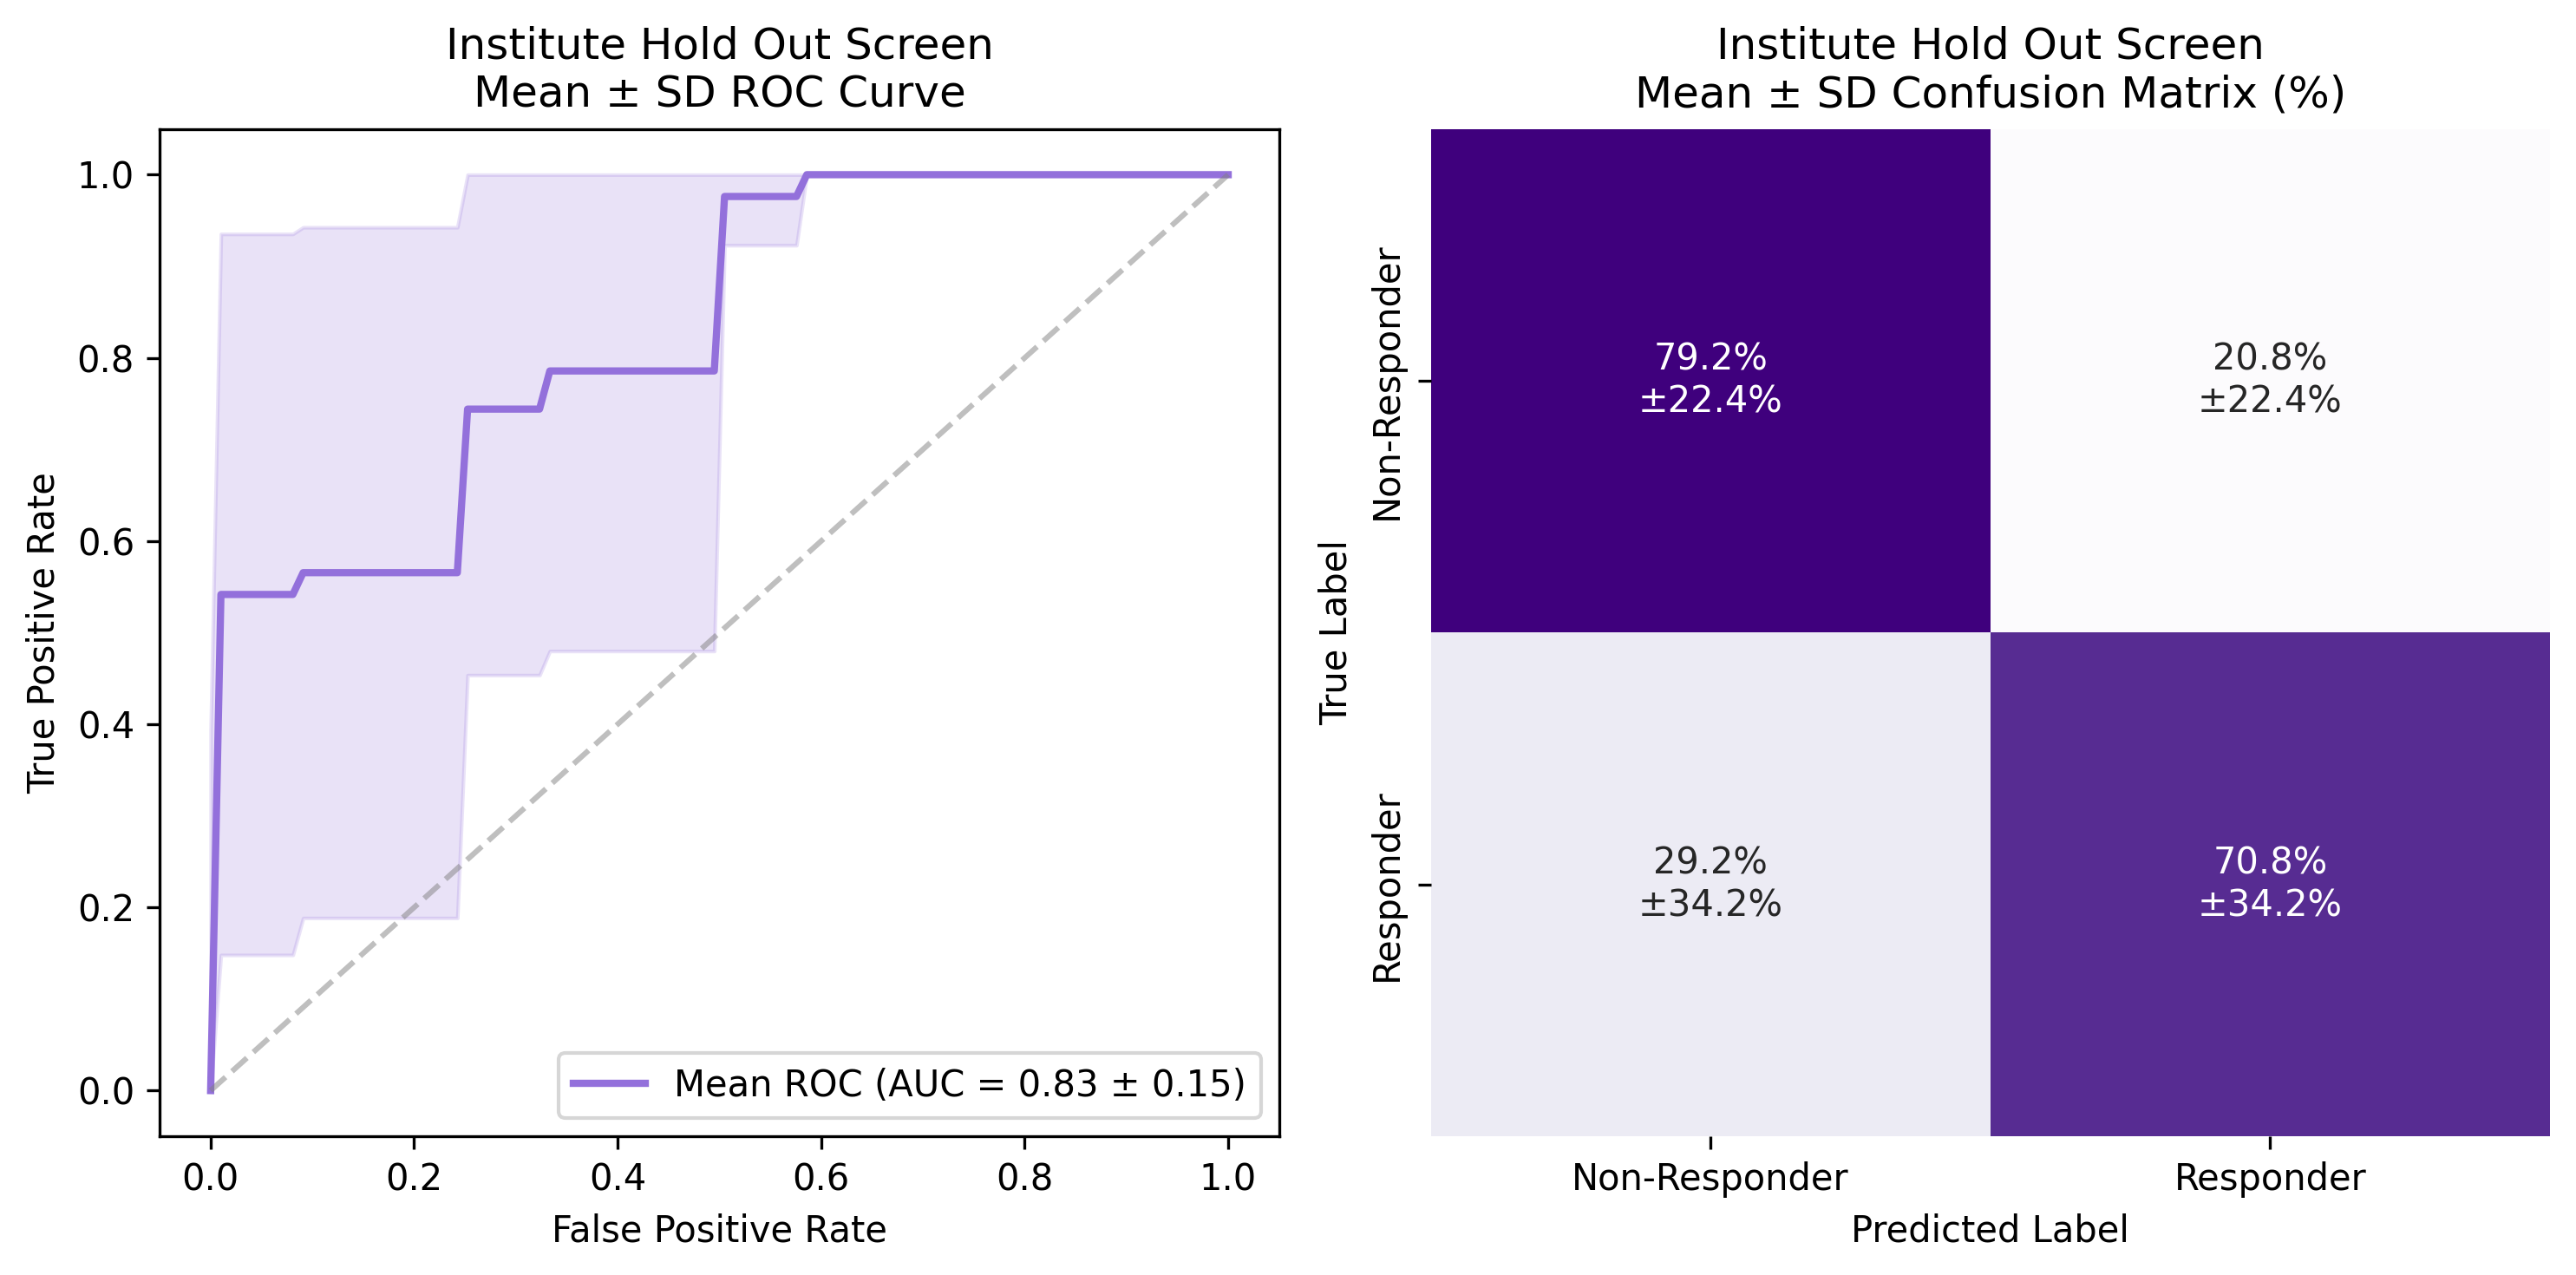

Found 6 metrics matching pattern: MDS_Institute_Hold_Out_*_Day_0
6
Institute Hold Out Day 0 AUC STD_0.212
Sensitivity at 90% specificity: 0.724 ± 0.277
Sensitivity at 95% specificity: 0.724 ± 0.277


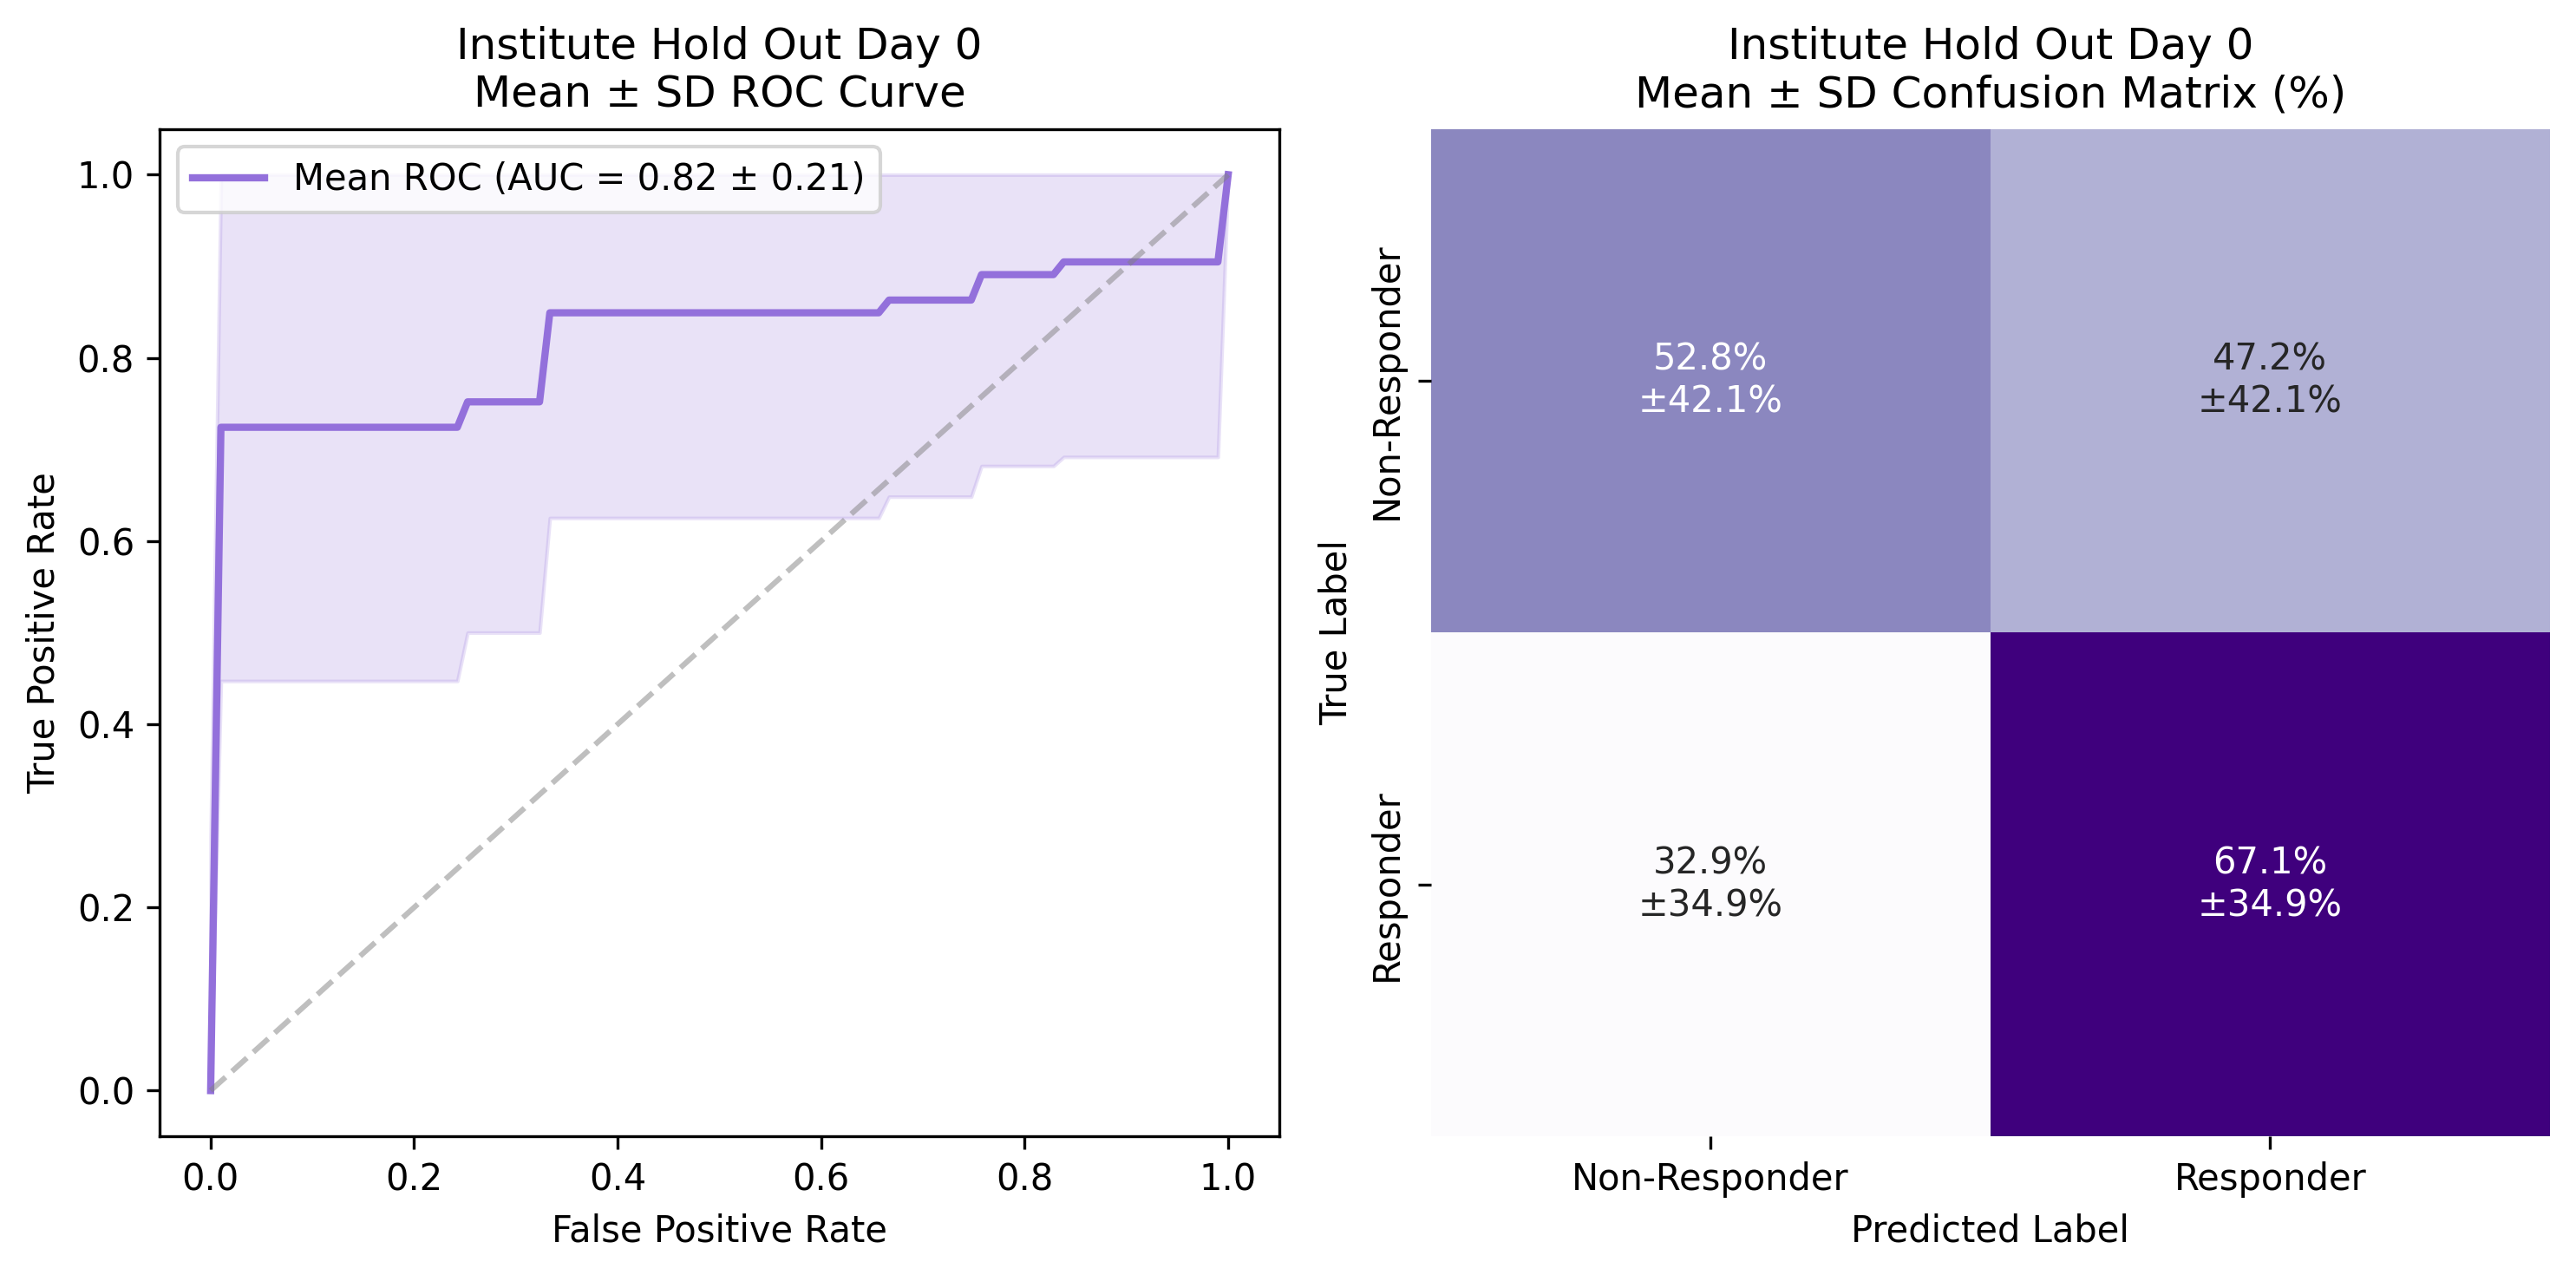

Found 6 metrics matching pattern: MDS_Institute_Hold_Out_*_Adj_Wk_1
6
Institute Hold Out Adj Wk 1 AUC STD_0.136
Sensitivity at 90% specificity: 0.879 ± 0.271
Sensitivity at 95% specificity: 0.848 ± 0.339


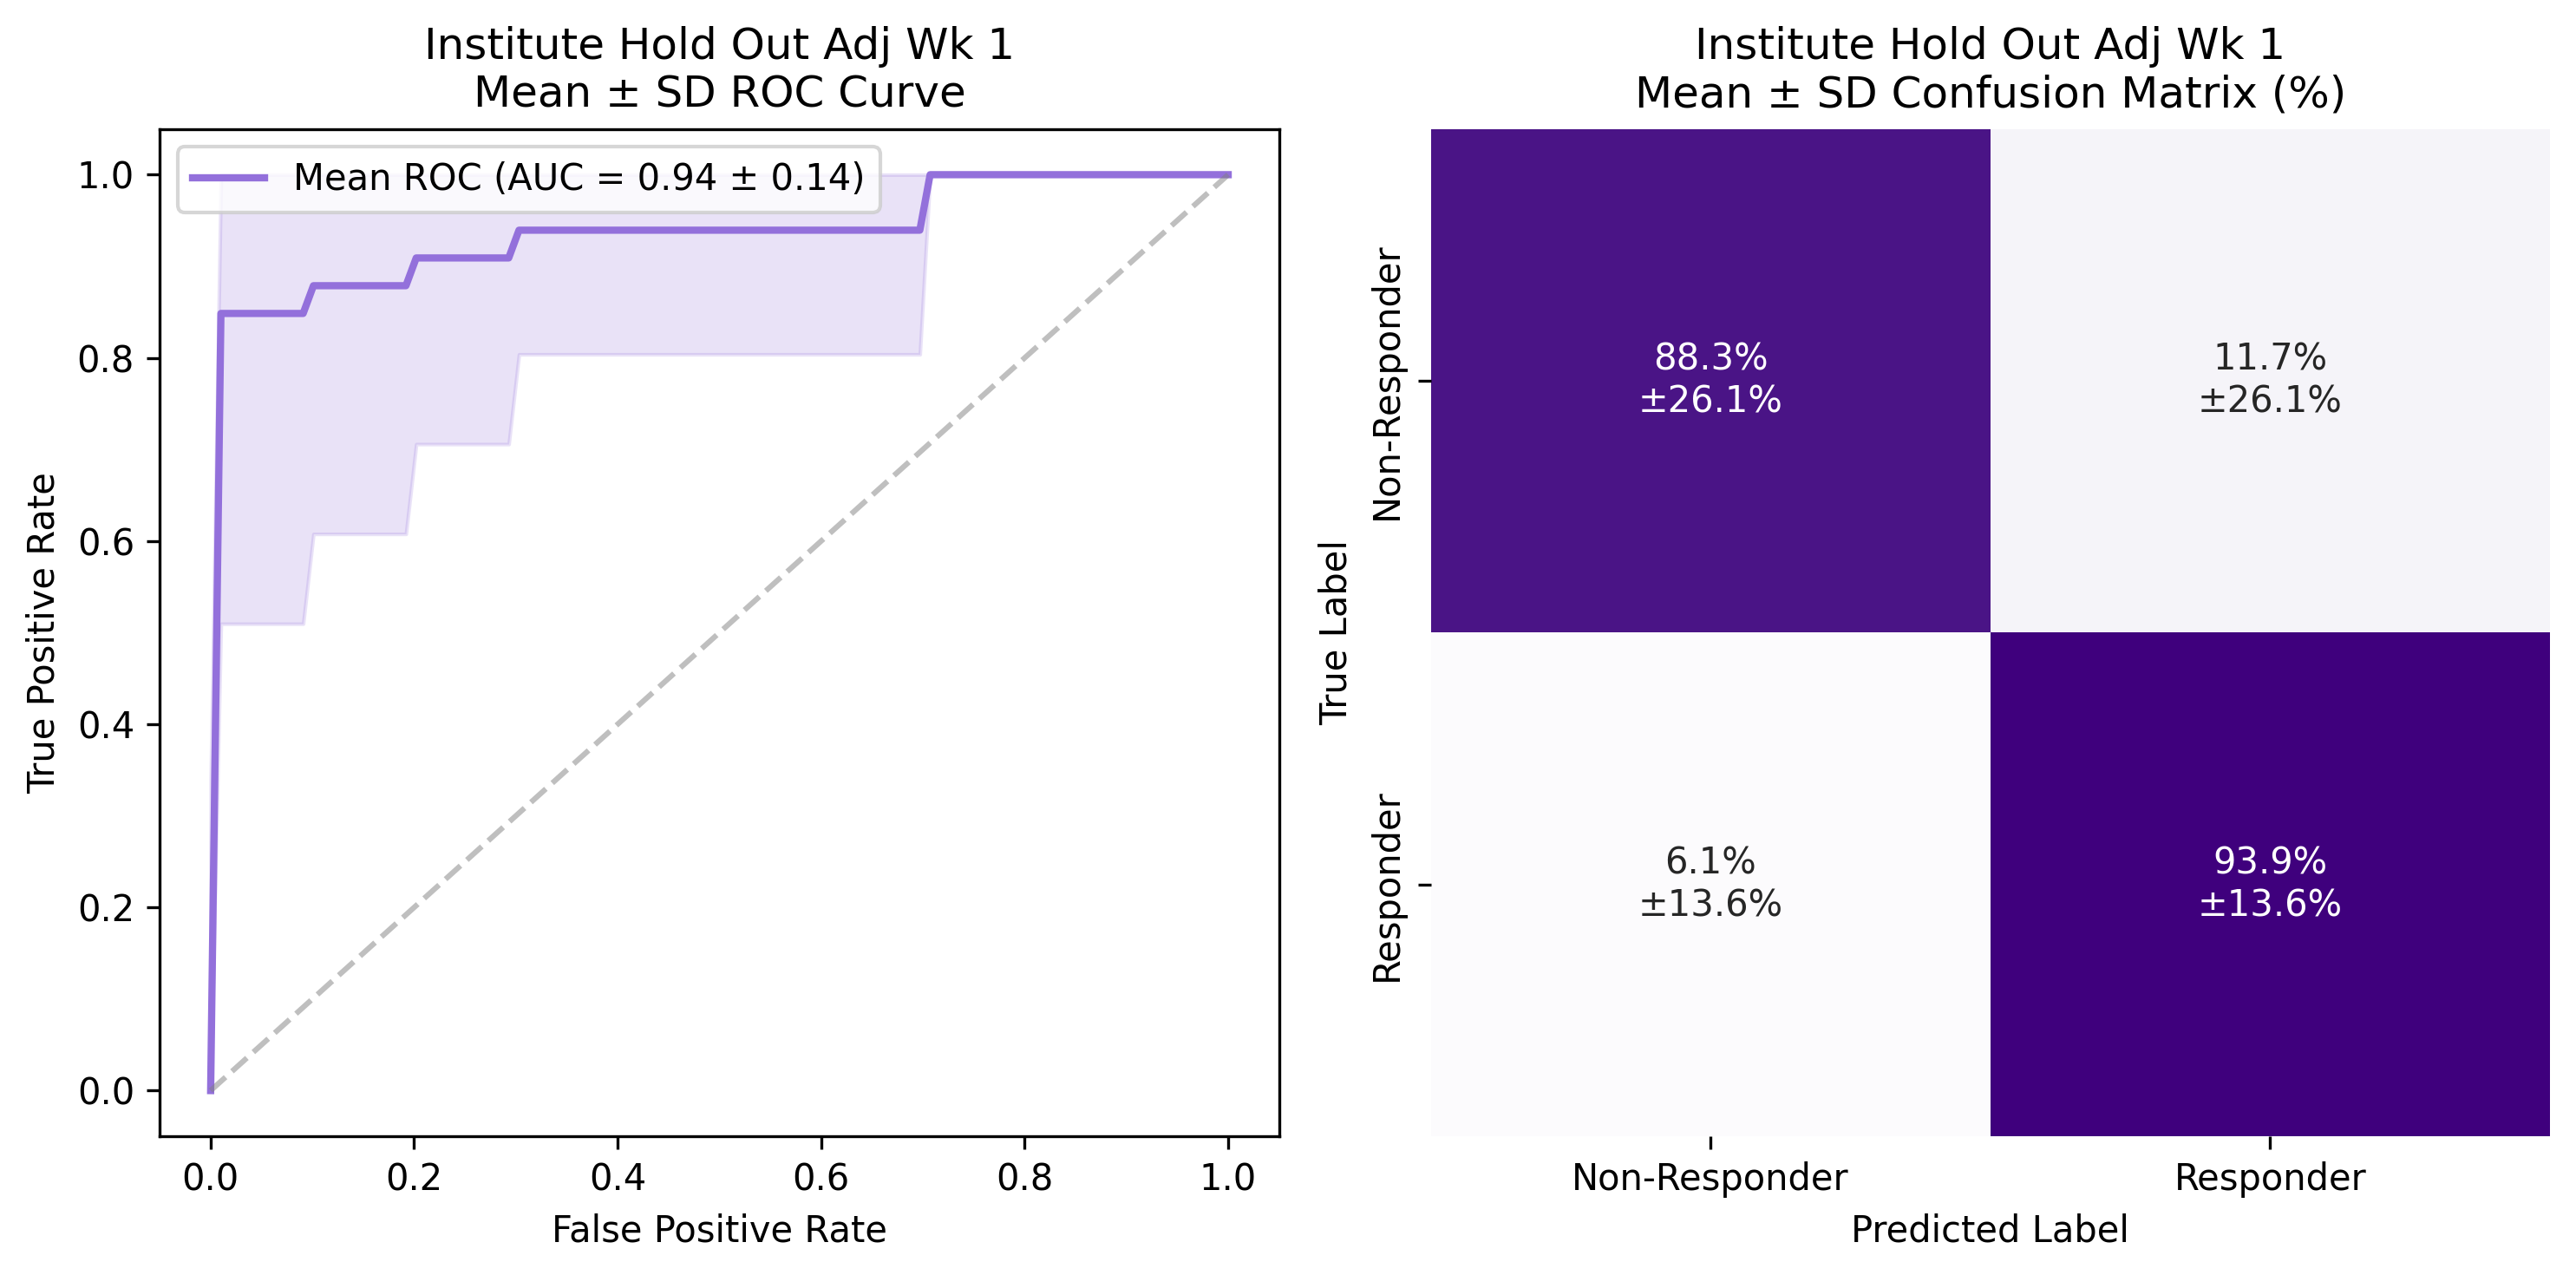

Found 6 metrics matching pattern: MDS_Institute_Hold_Out_*_Overall
6
Institute Hold Out Overall AUC STD_0.129
Sensitivity at 90% specificity: 0.633 ± 0.220
Sensitivity at 95% specificity: 0.559 ± 0.266


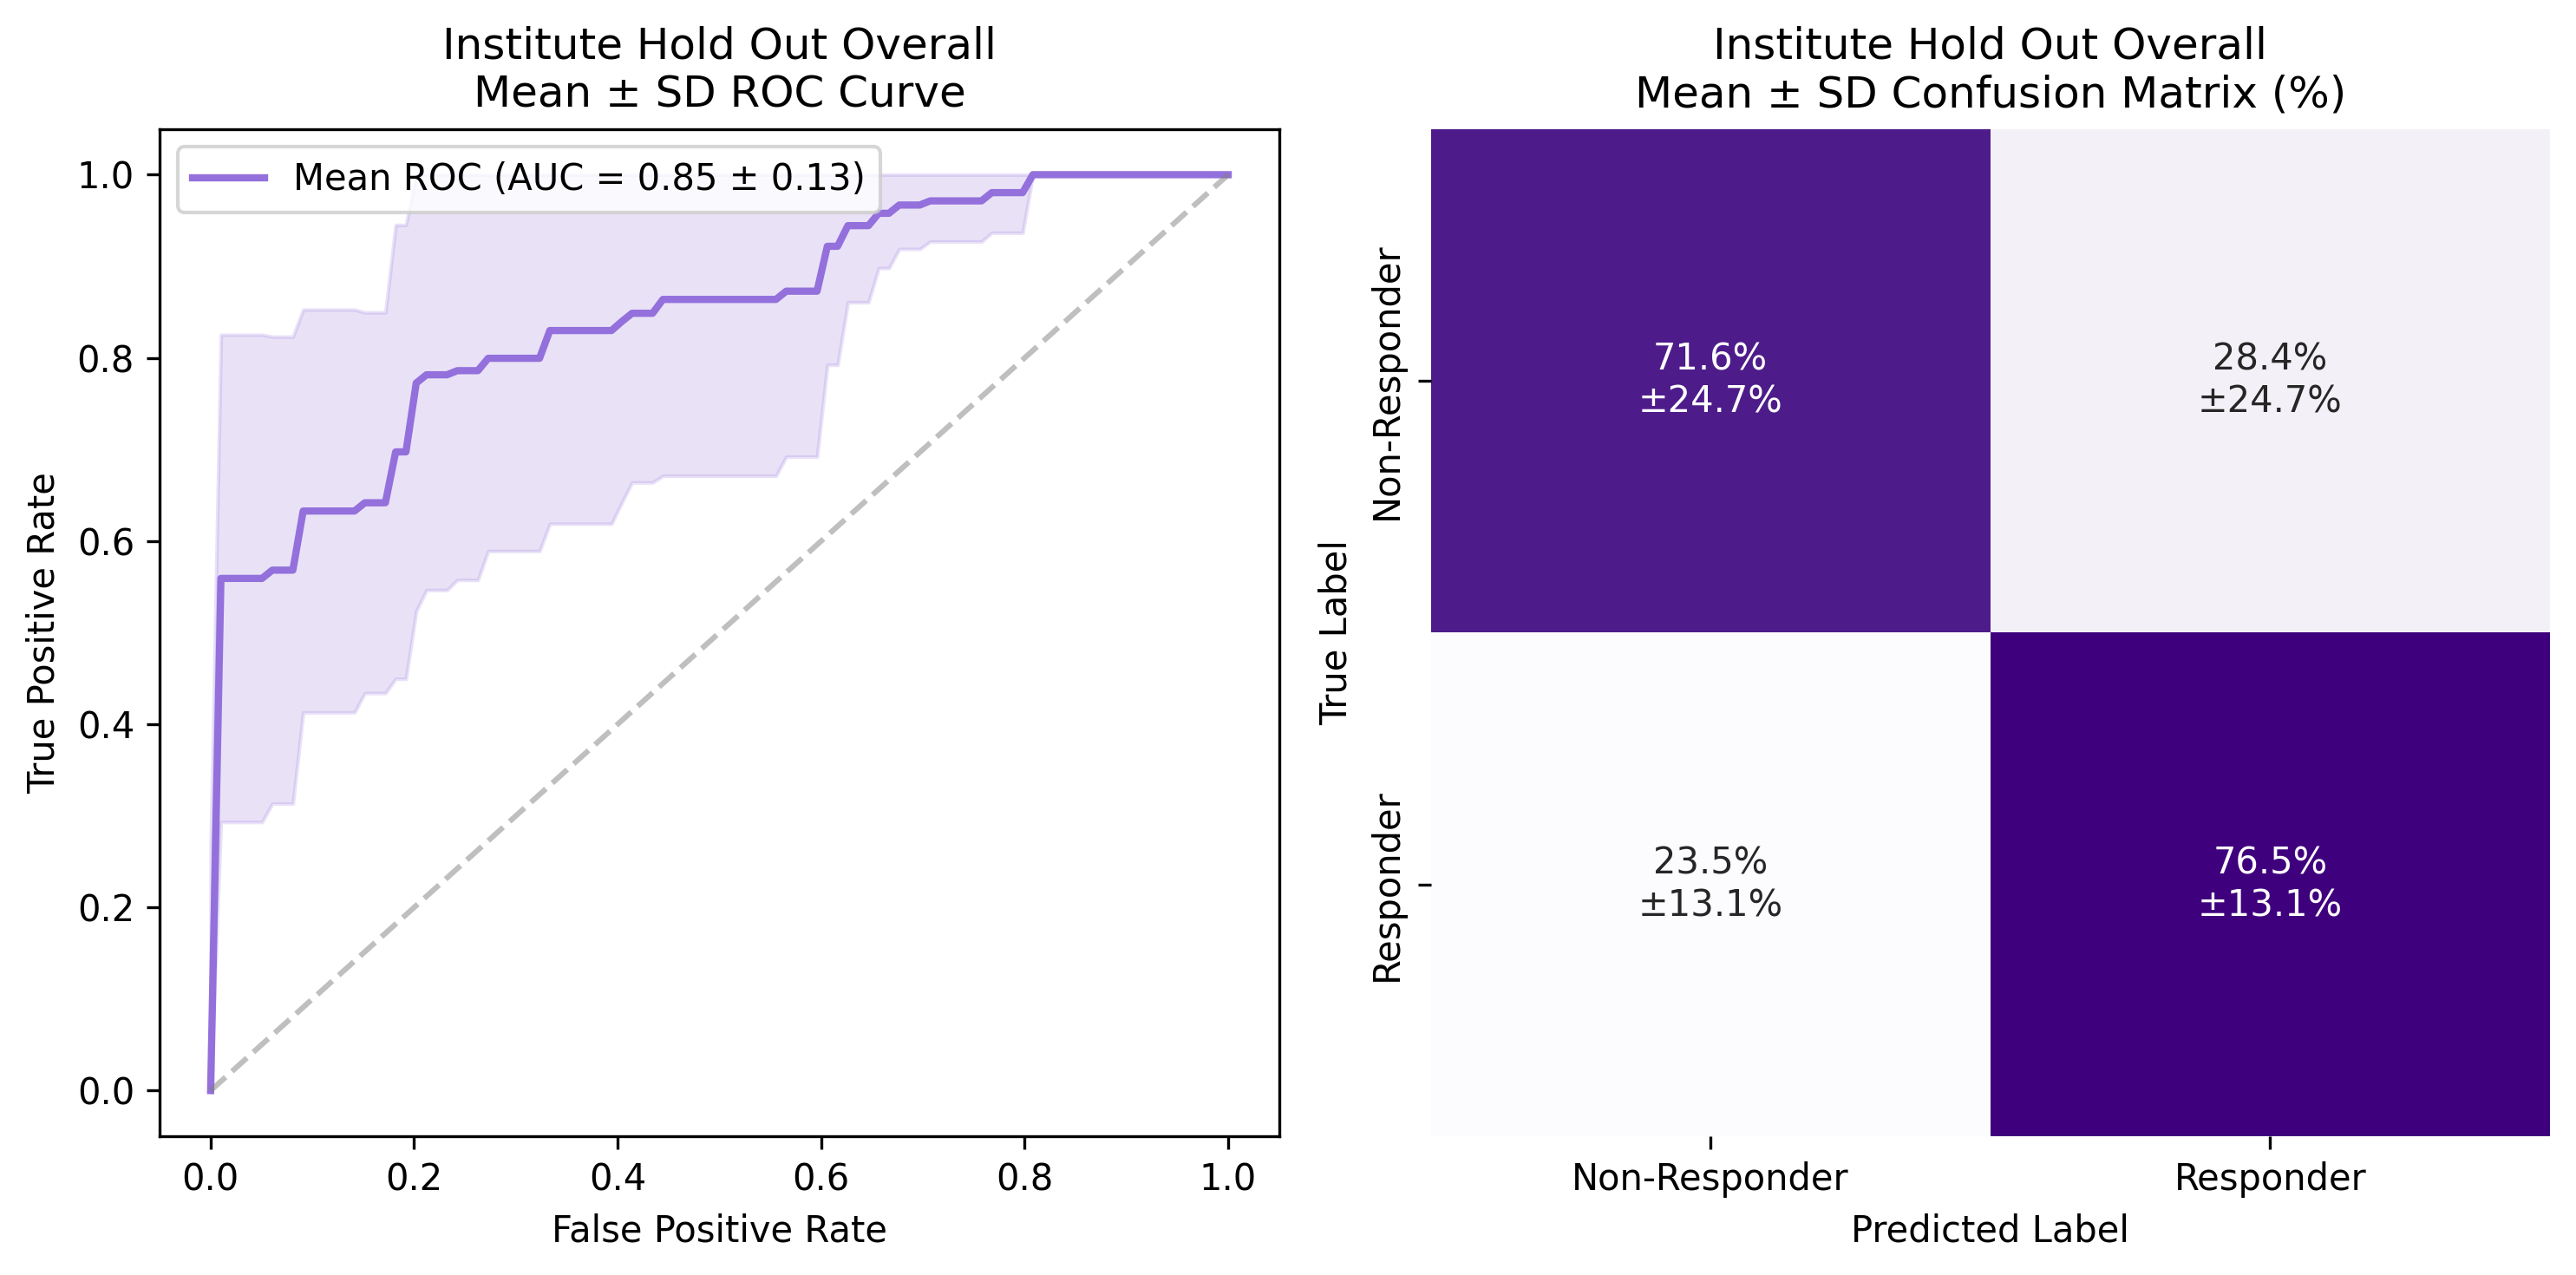

Found 6 metrics matching pattern: MDS_Institute_Hold_Out_*_Patient
6
Institute Hold Out Patient Level AUC STD_0.120
Sensitivity at 90% specificity: 0.777 ± 0.263
Sensitivity at 95% specificity: 0.753 ± 0.309


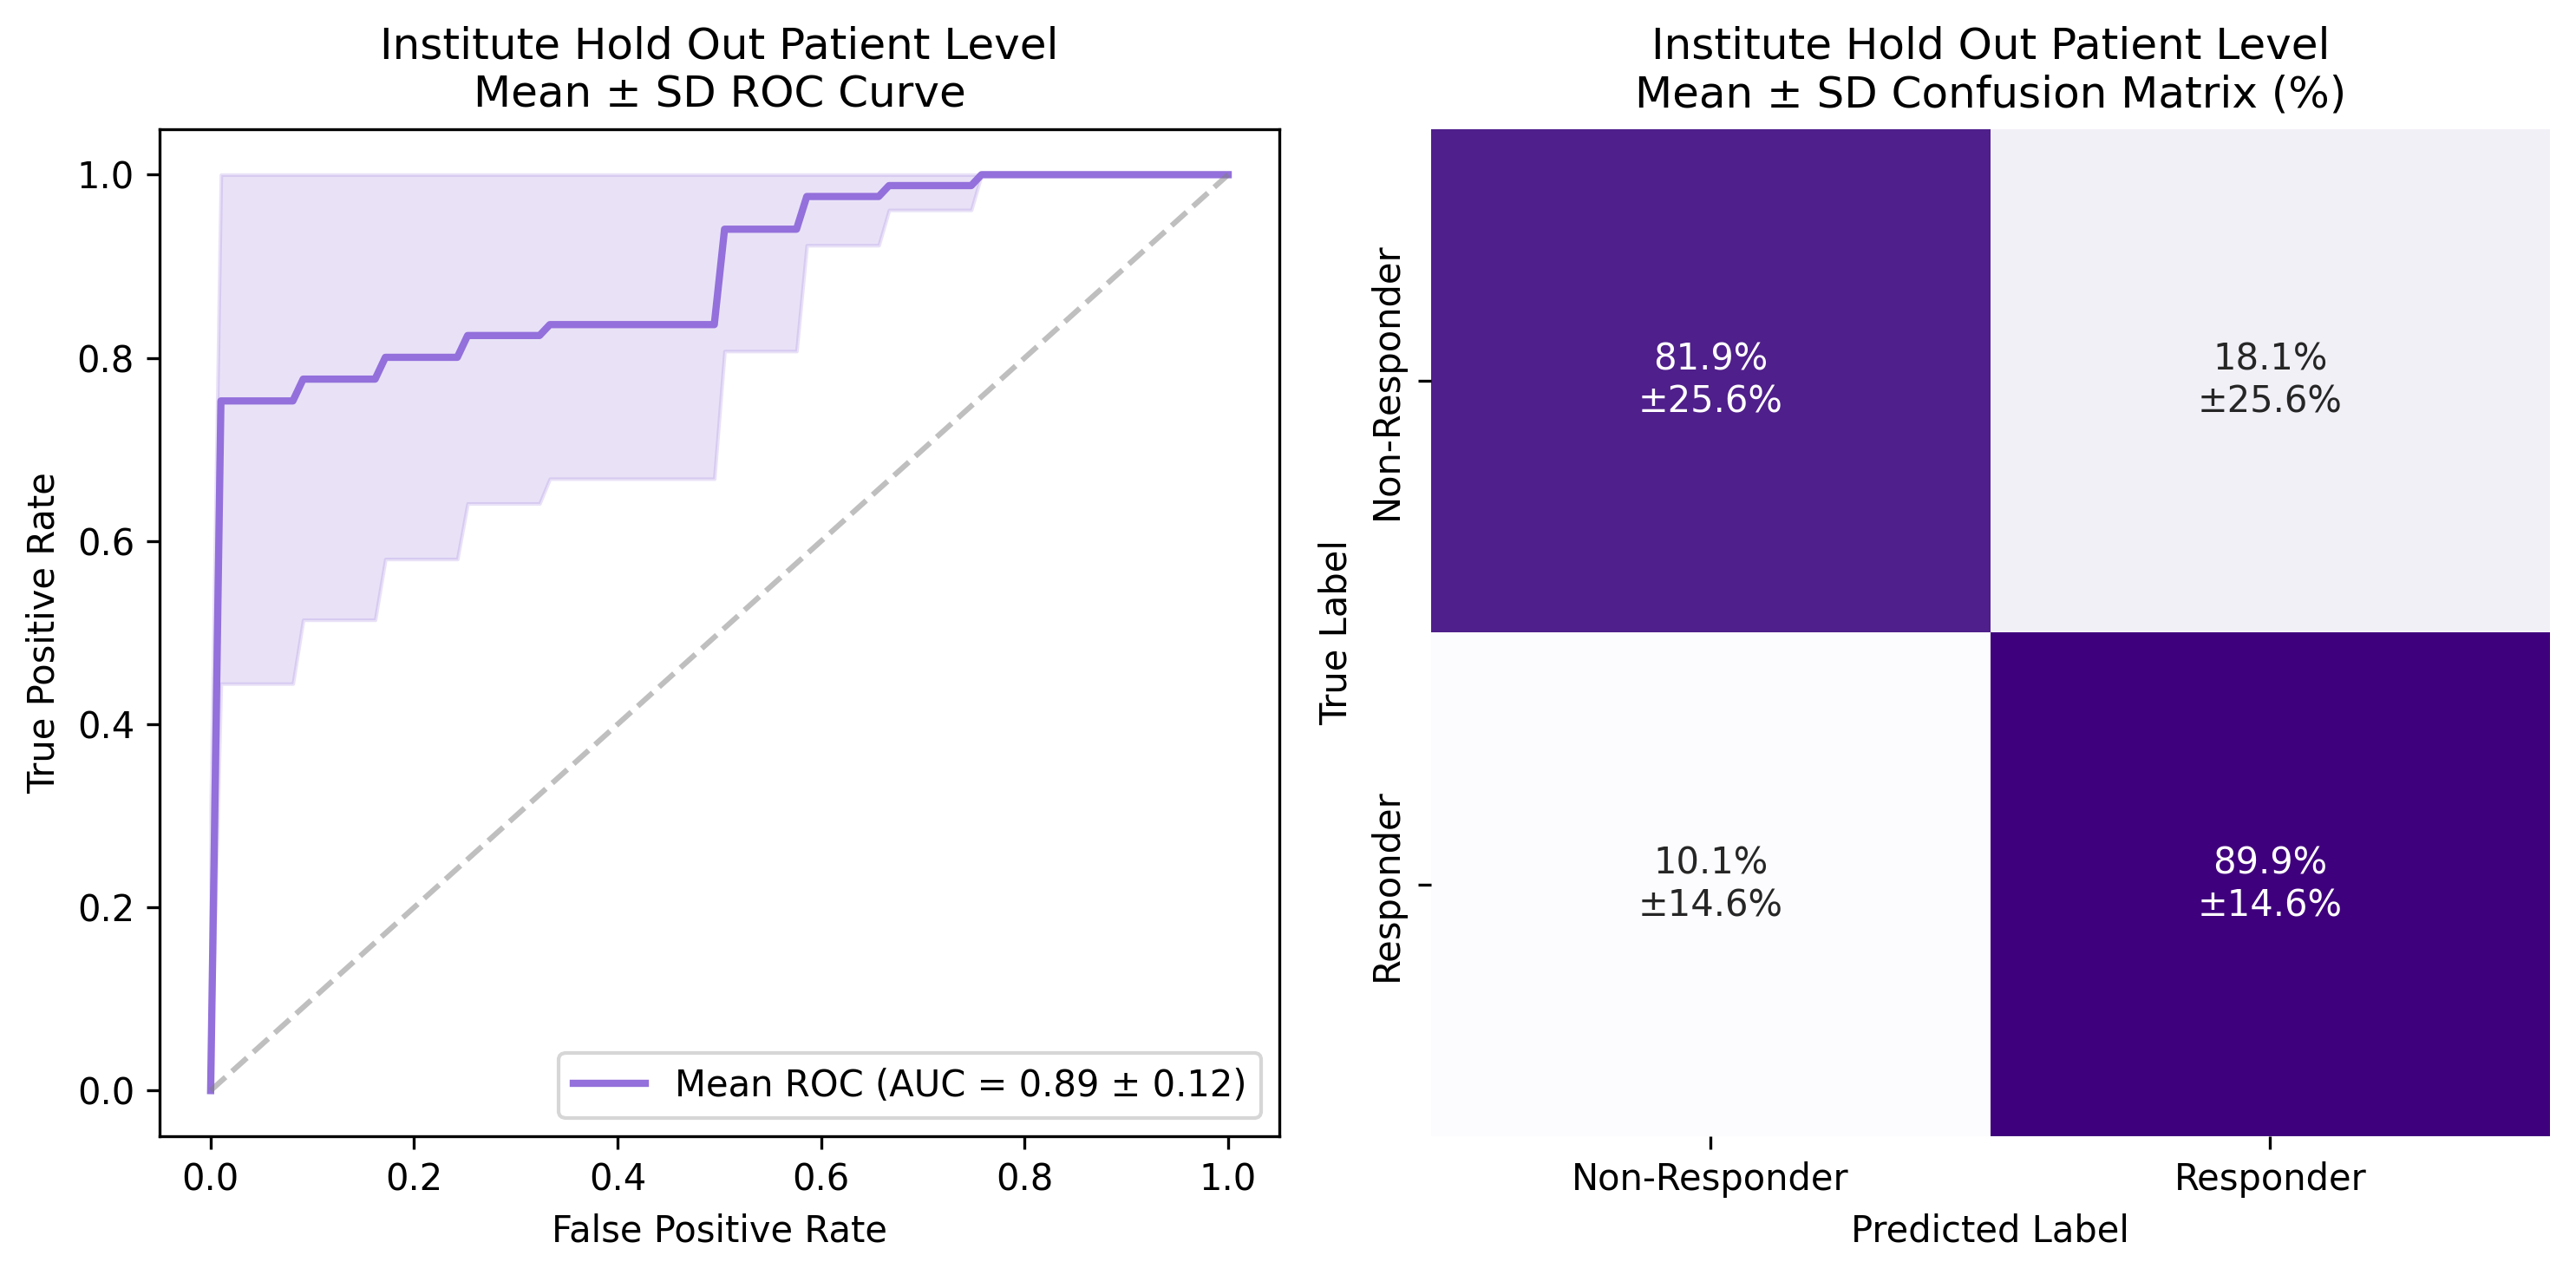

Found 100 metrics matching pattern: MDS_Pre_Hold_Out_*_Screen
100
Pre Hold Out Screen AUC STD_0.178
Sensitivity at 90% specificity: 0.368 ± 0.261
Sensitivity at 95% specificity: 0.368 ± 0.261


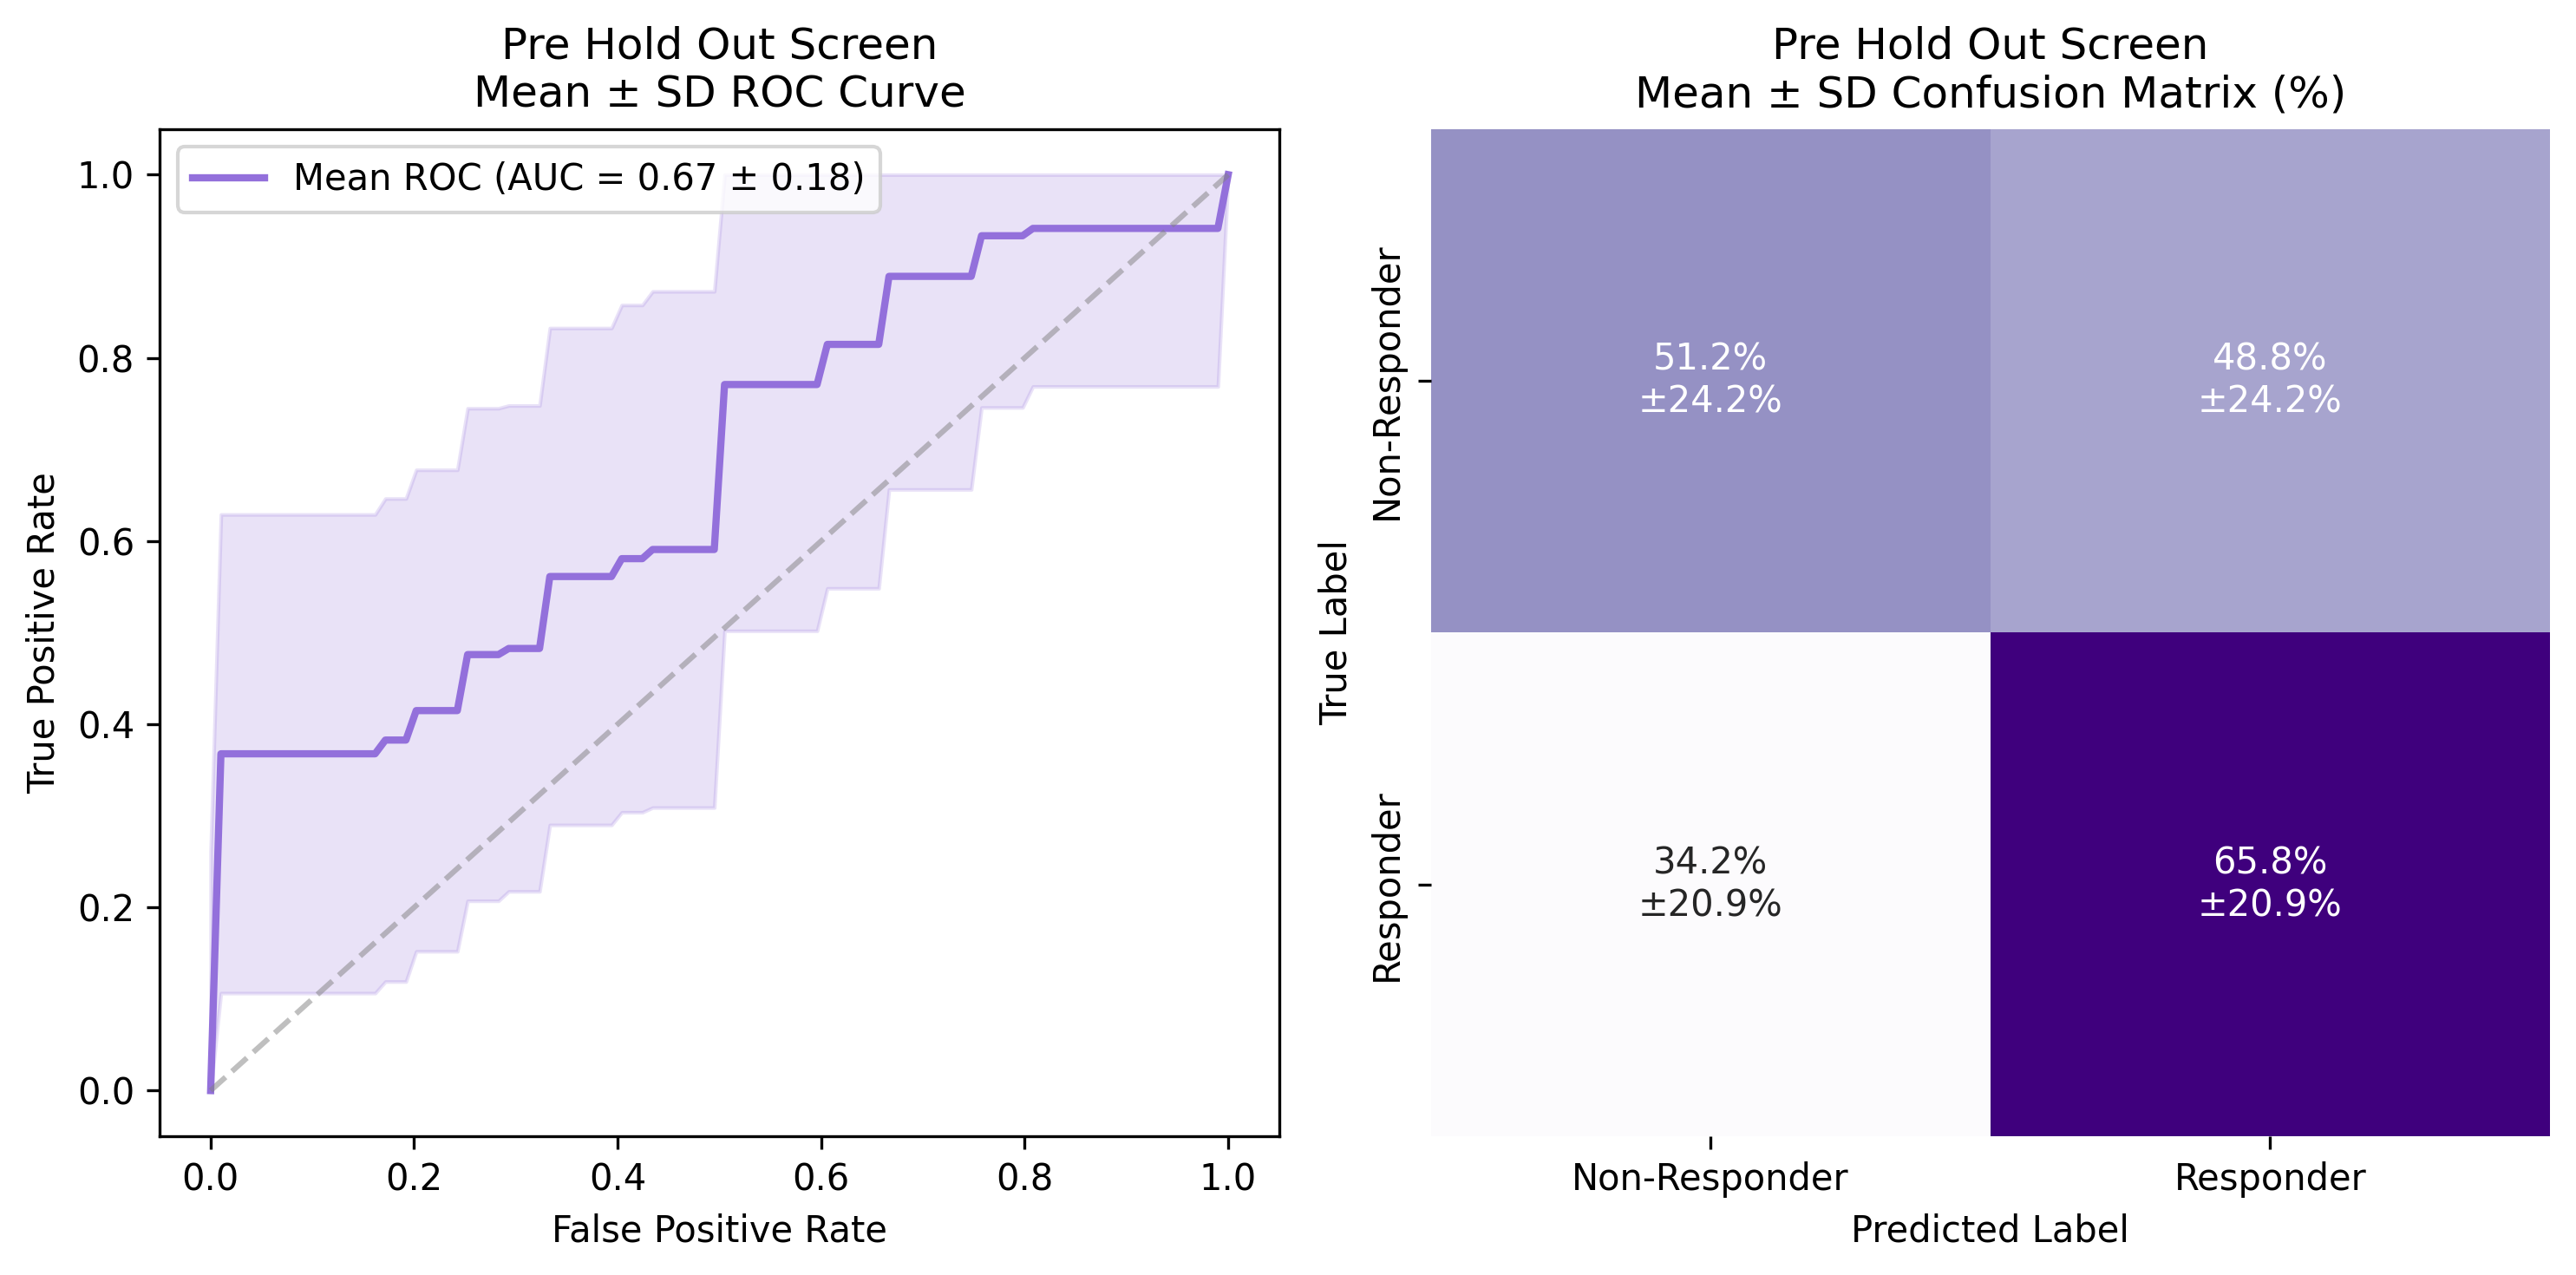

Found 100 metrics matching pattern: MDS_Pre_Hold_Out_*_Day_0
100
Pre Hold Out Day 0 AUC STD_0.204
Sensitivity at 90% specificity: 0.416 ± 0.274
Sensitivity at 95% specificity: 0.416 ± 0.274


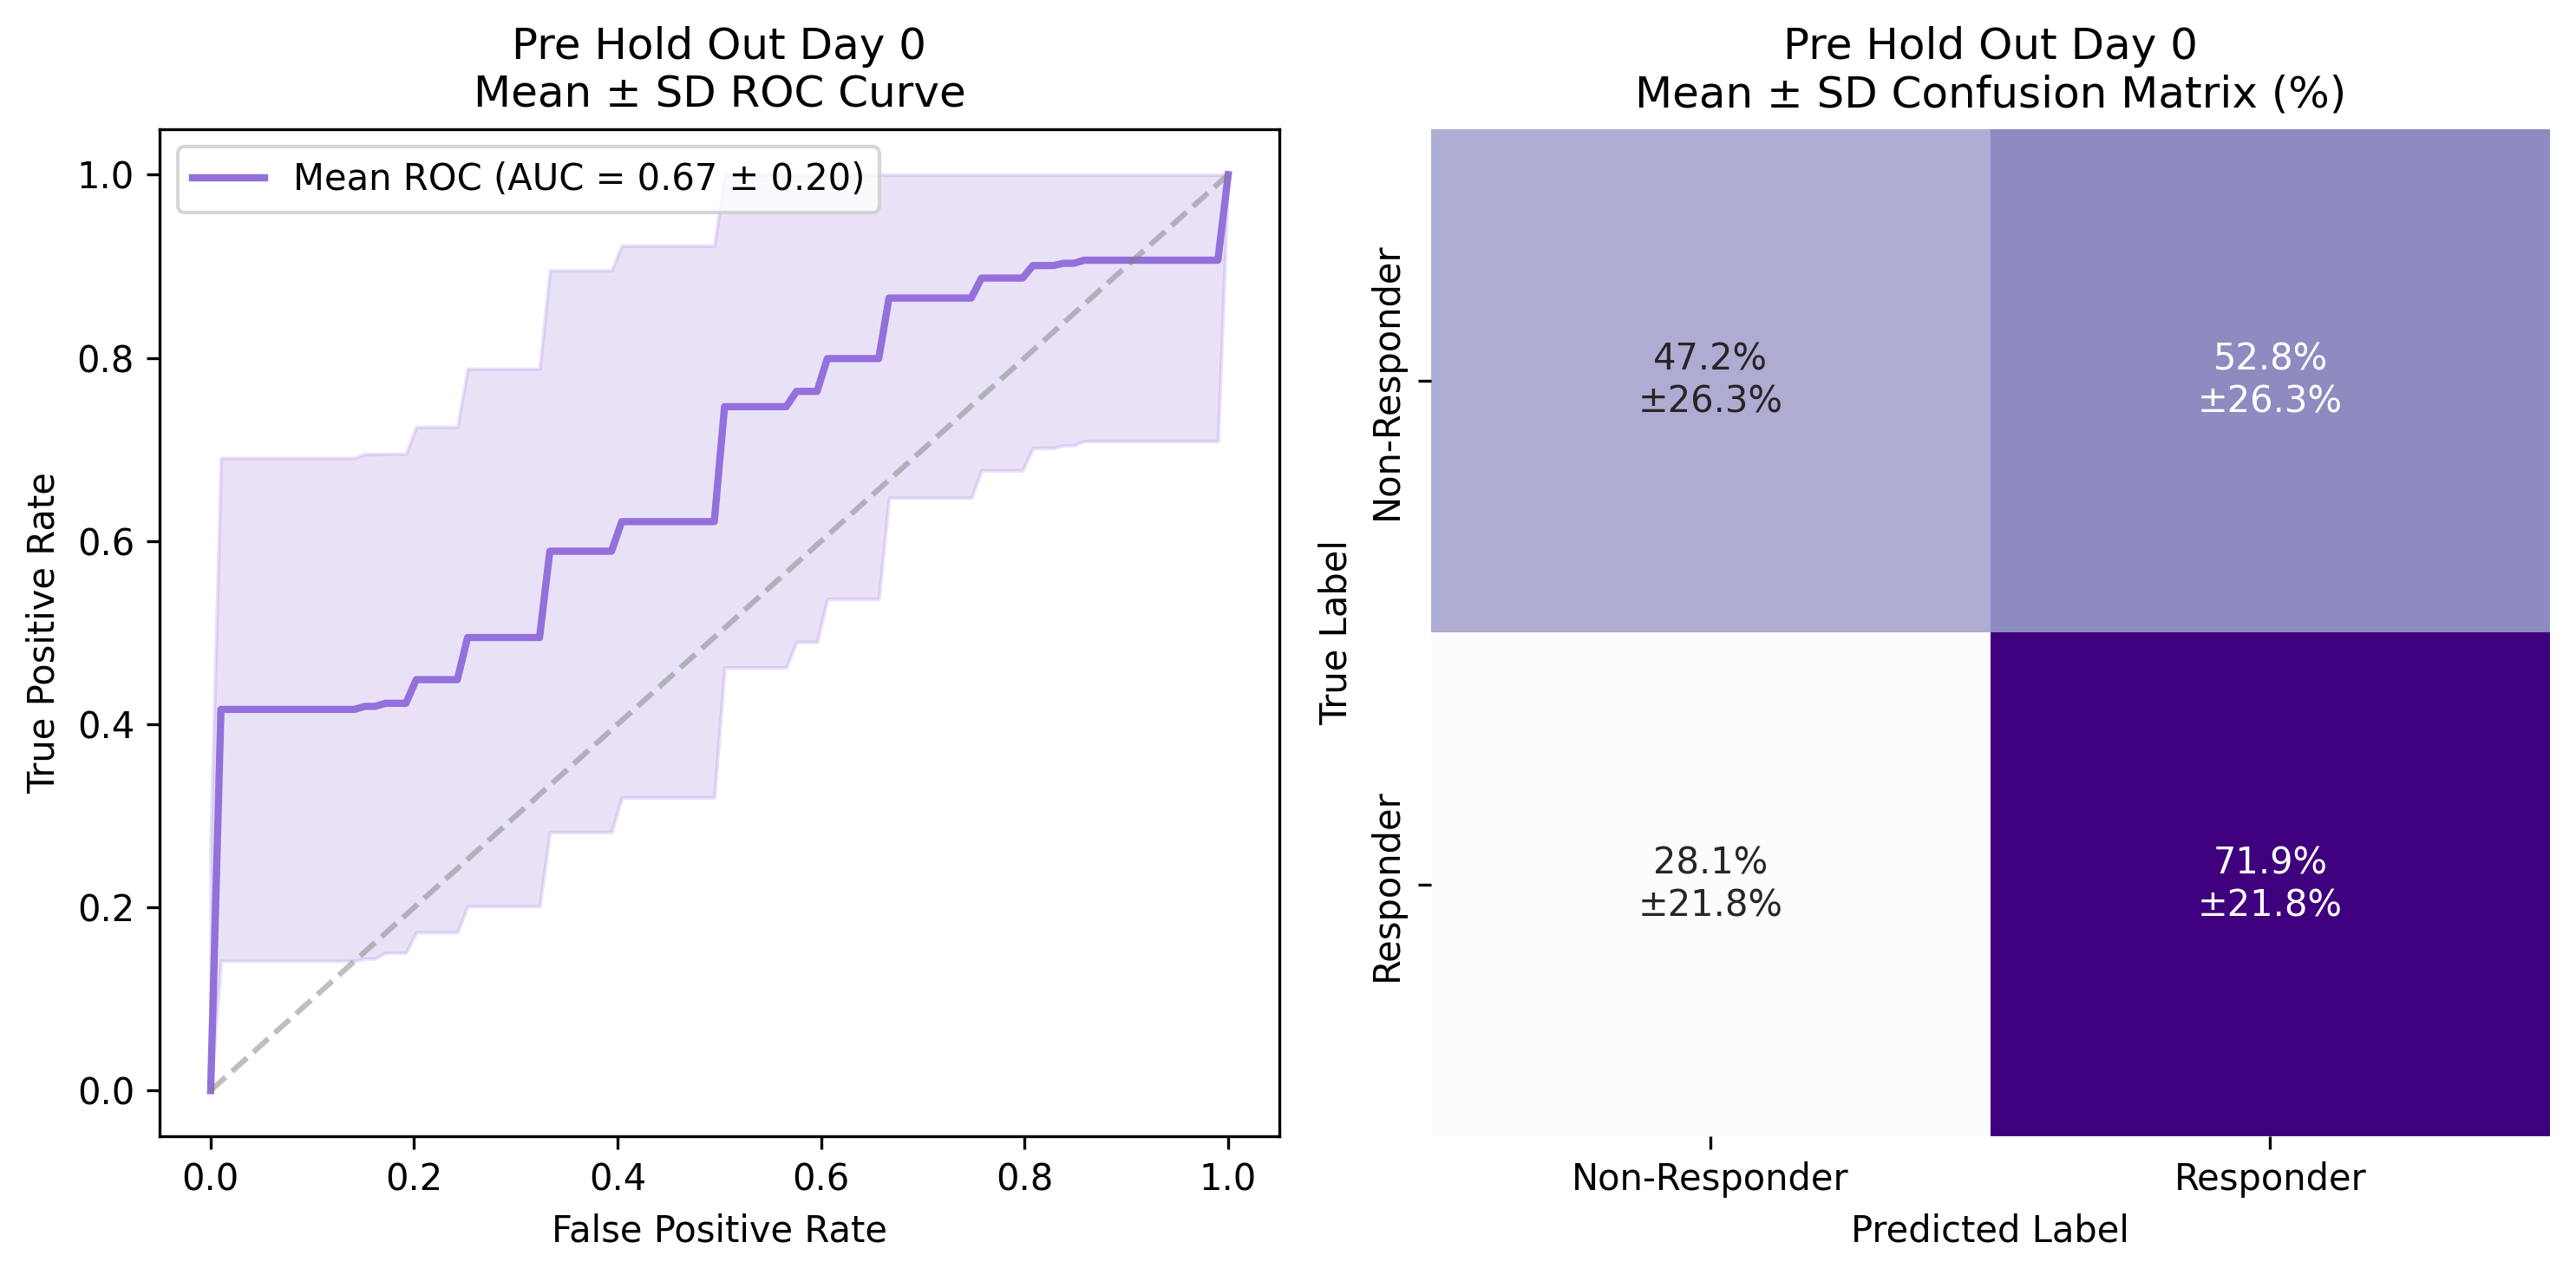

Found 100 metrics matching pattern: MDS_Pre_Hold_Out_*_Adj_Wk_1
98
Pre Hold Out Adj Wk 1 AUC STD_0.227
Sensitivity at 90% specificity: 0.424 ± 0.344
Sensitivity at 95% specificity: 0.424 ± 0.344


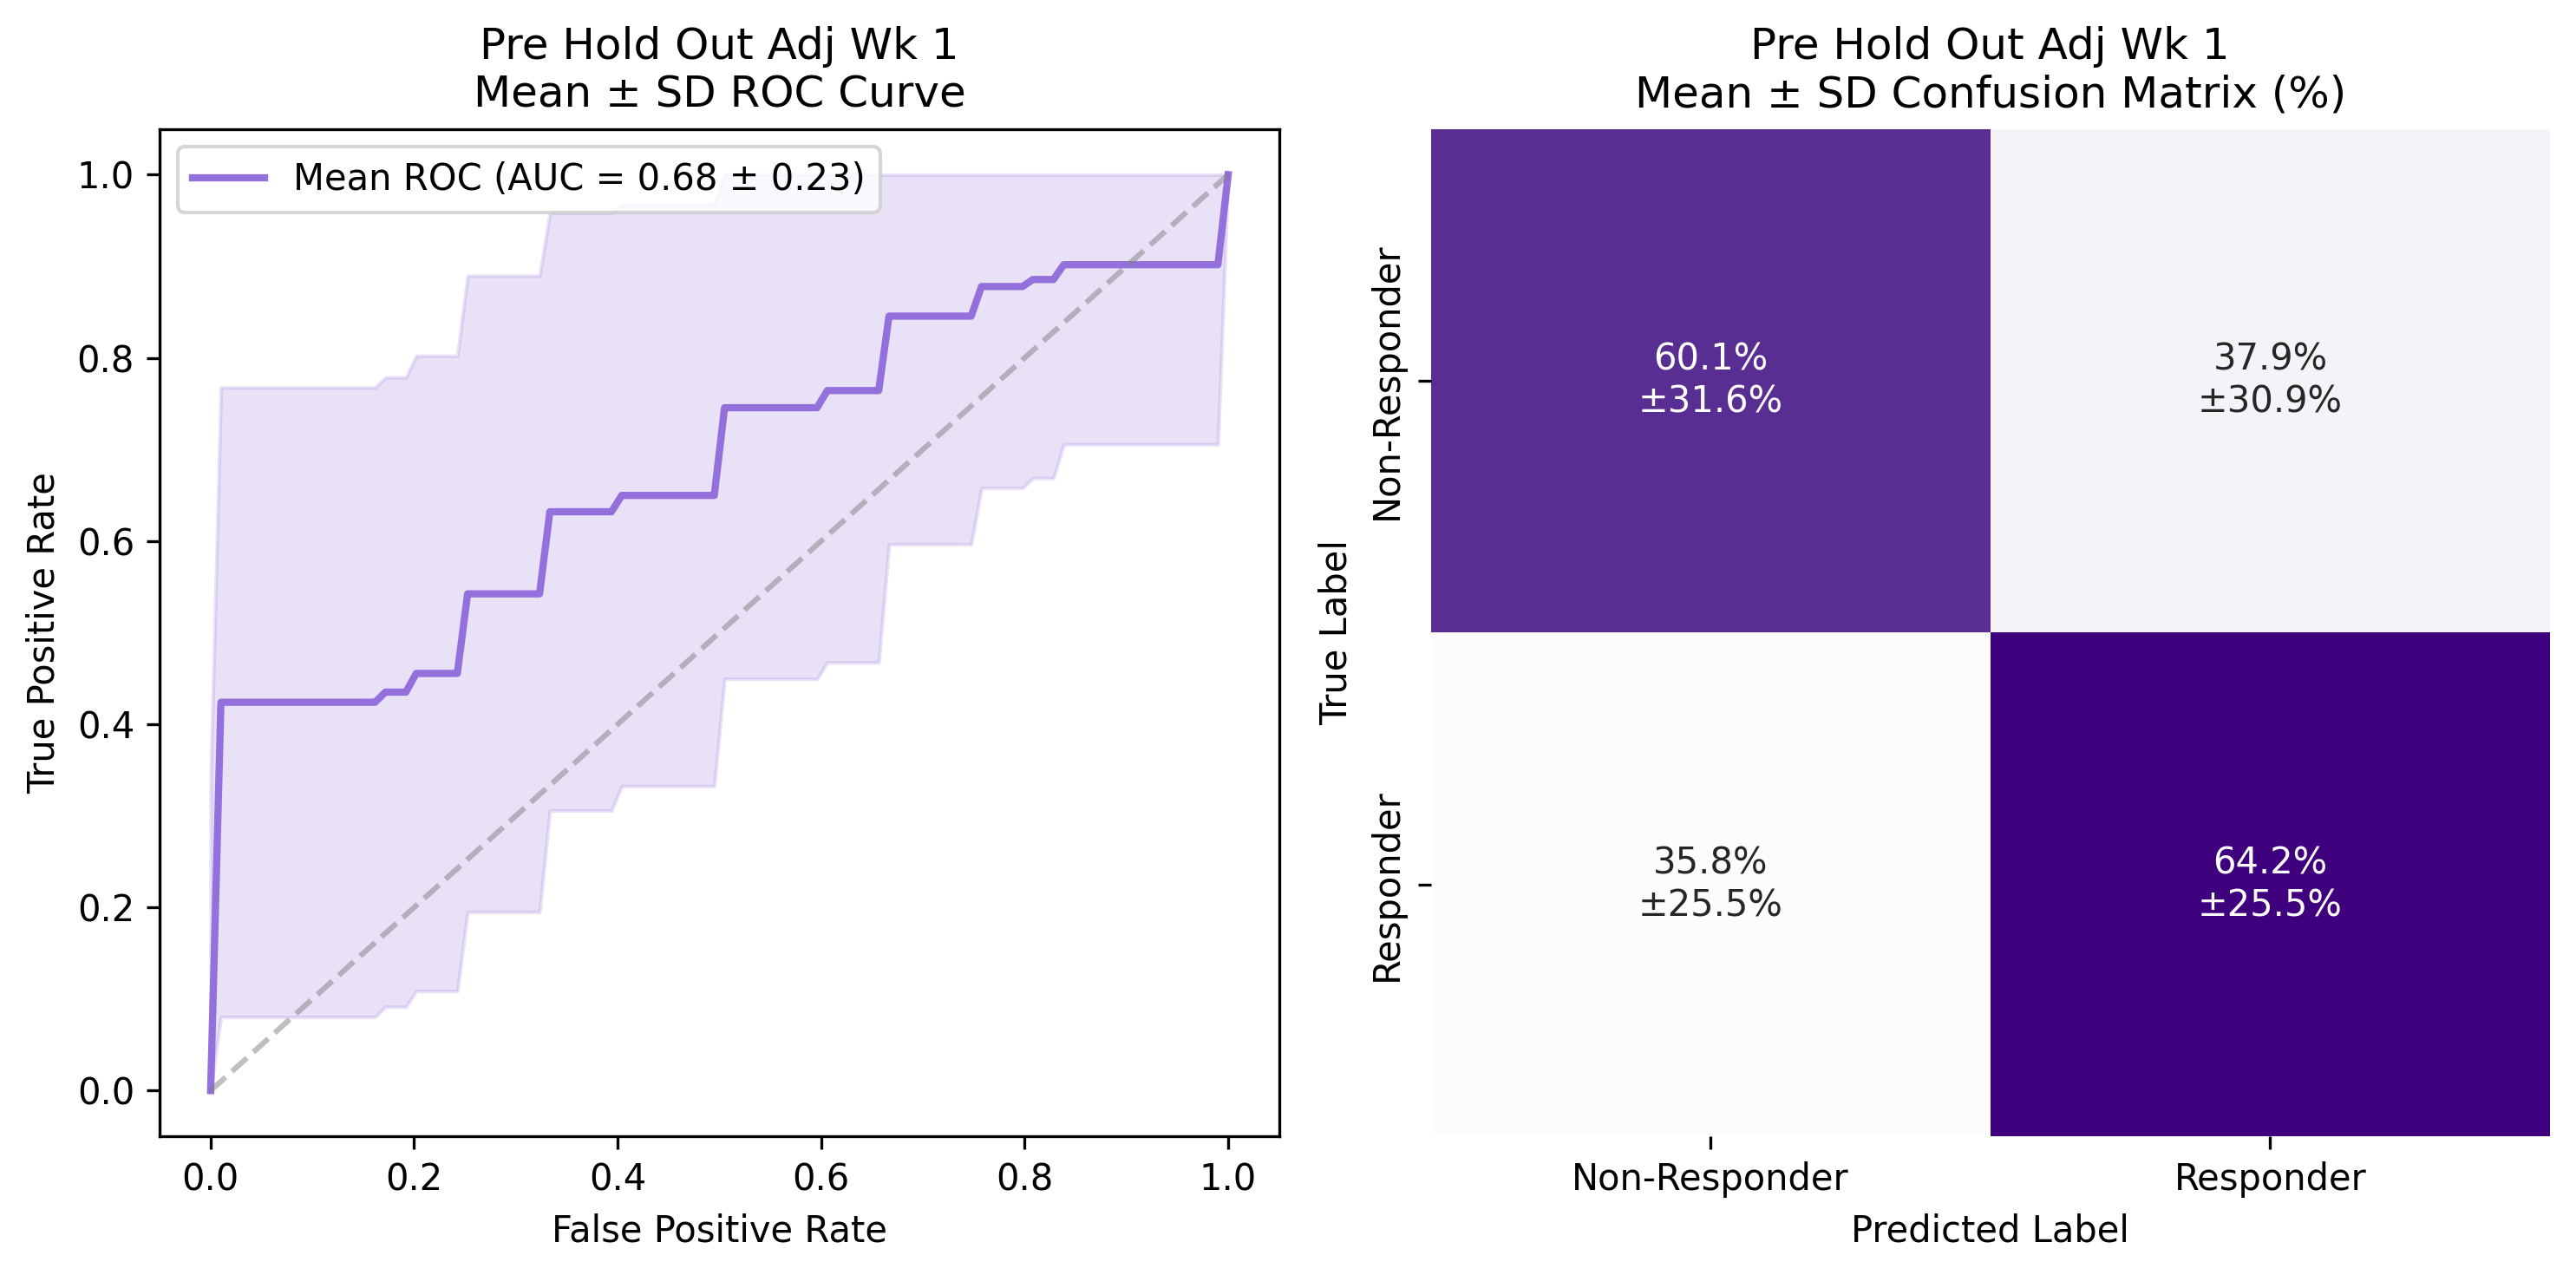

Found 100 metrics matching pattern: MDS_Pre_Hold_Out_*_Overall
100
Pre Hold Out Overall AUC STD_0.170
Sensitivity at 90% specificity: 0.339 ± 0.227
Sensitivity at 95% specificity: 0.295 ± 0.213


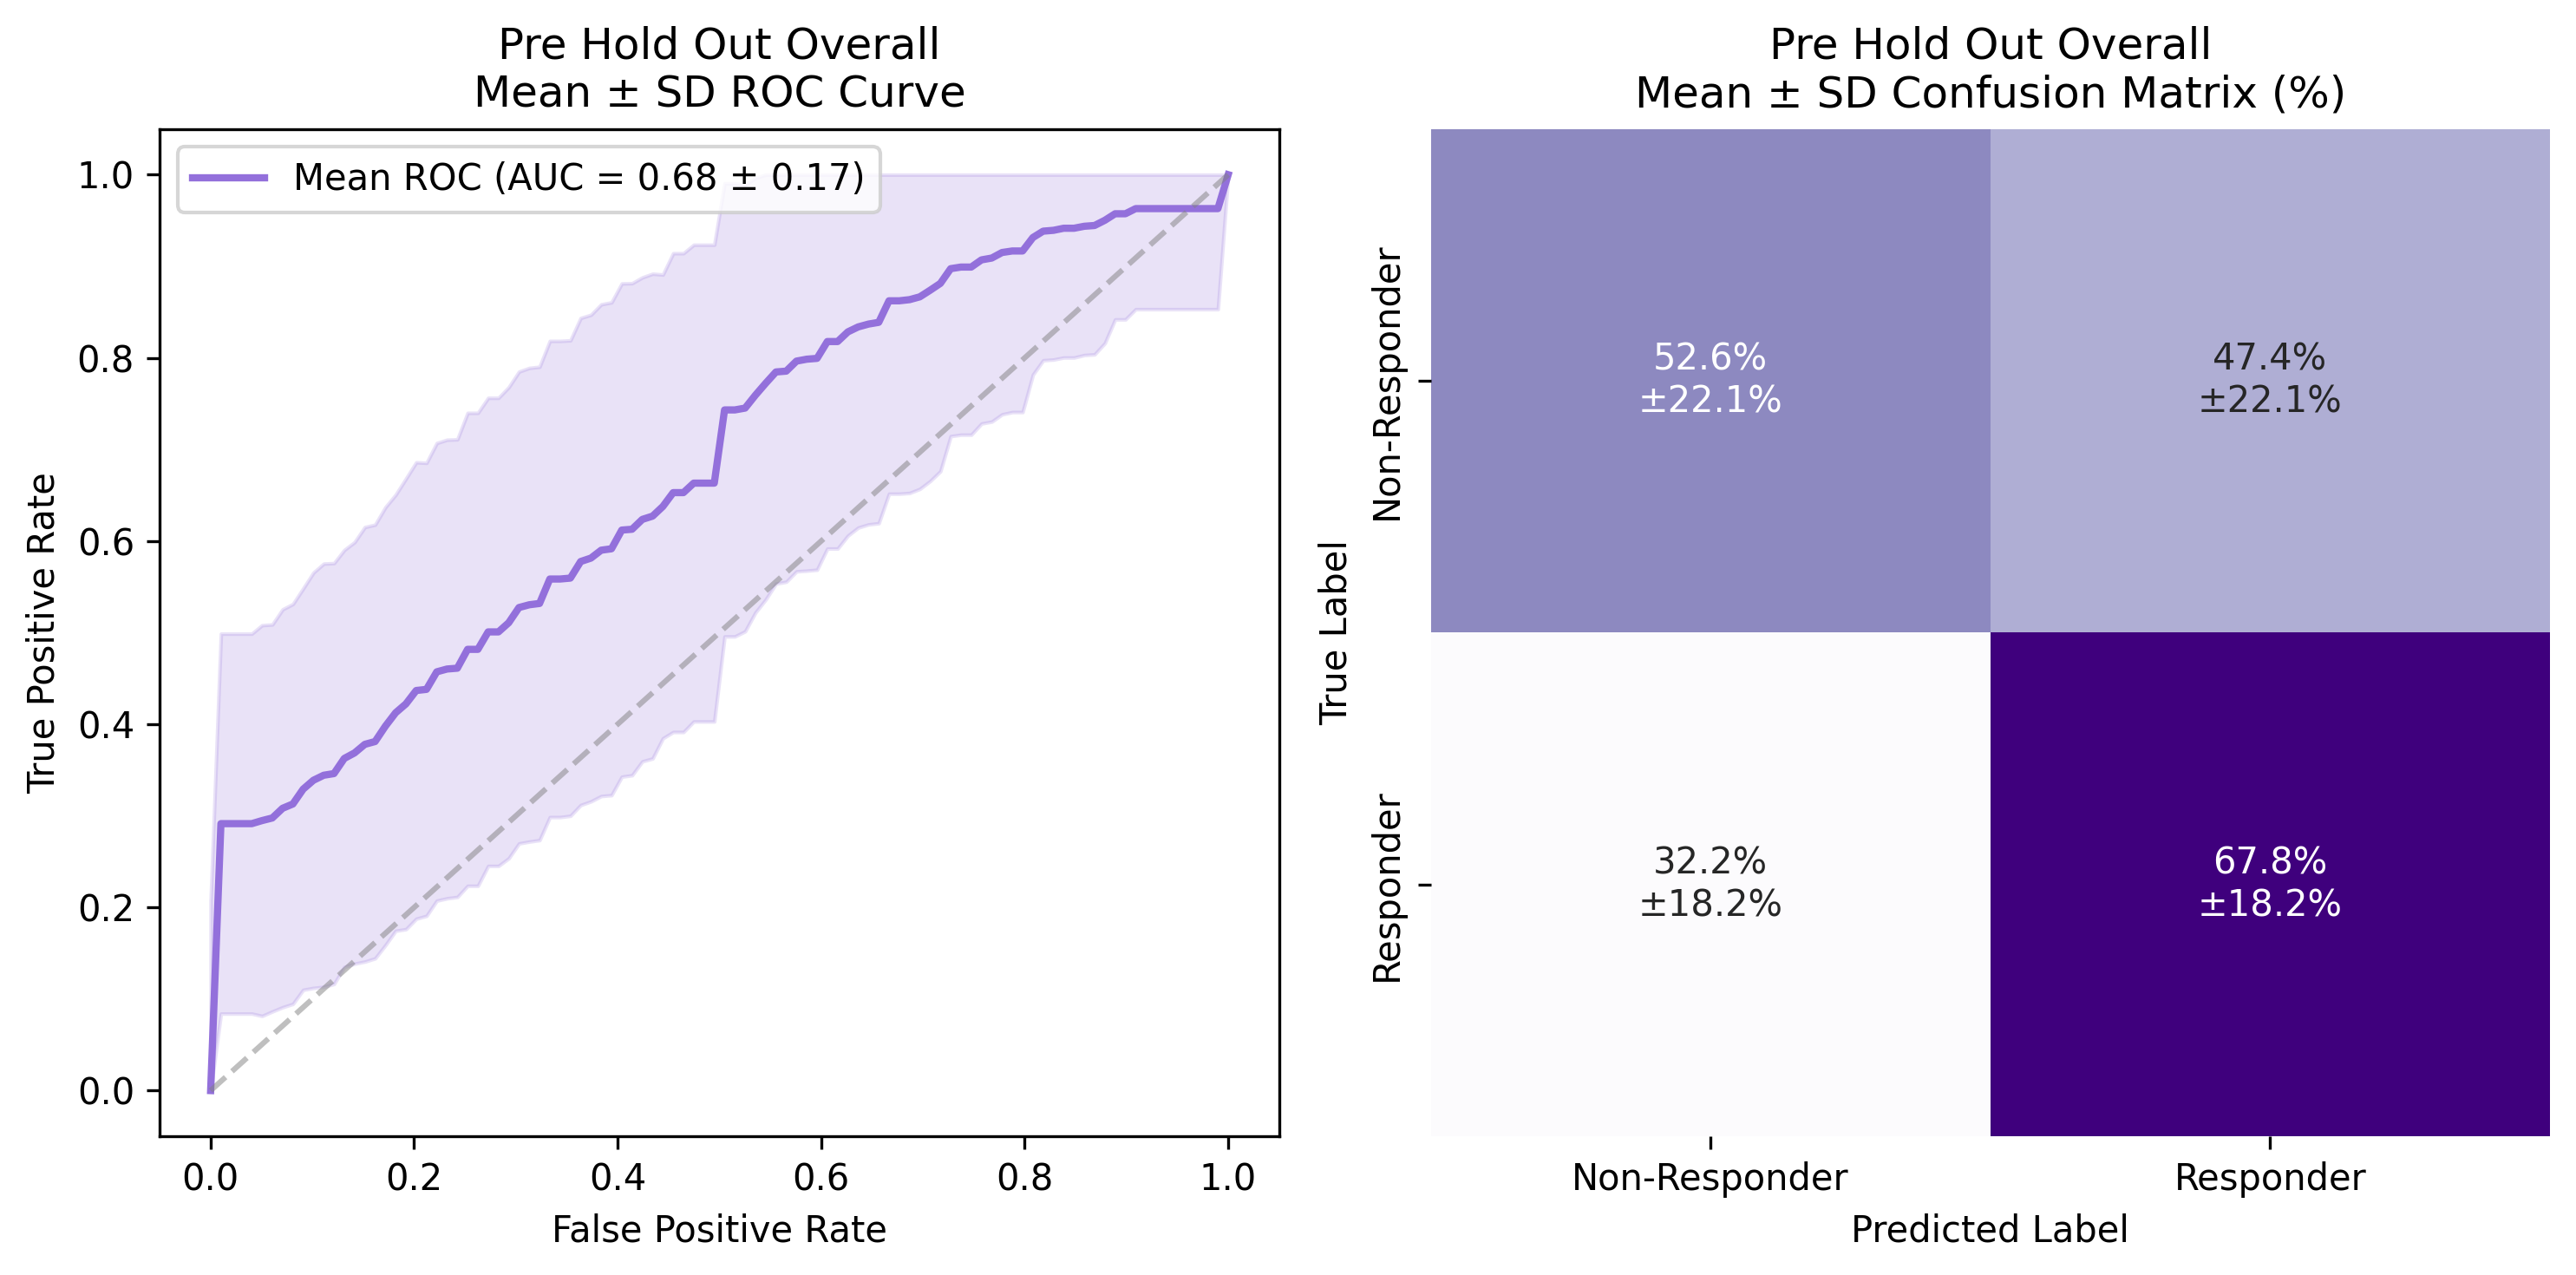

Found 100 metrics matching pattern: MDS_Pre_Hold_Out_*_Patient
100
Pre Hold Out Patient Level AUC STD_0.188
Sensitivity at 90% specificity: 0.379 ± 0.270
Sensitivity at 95% specificity: 0.379 ± 0.270


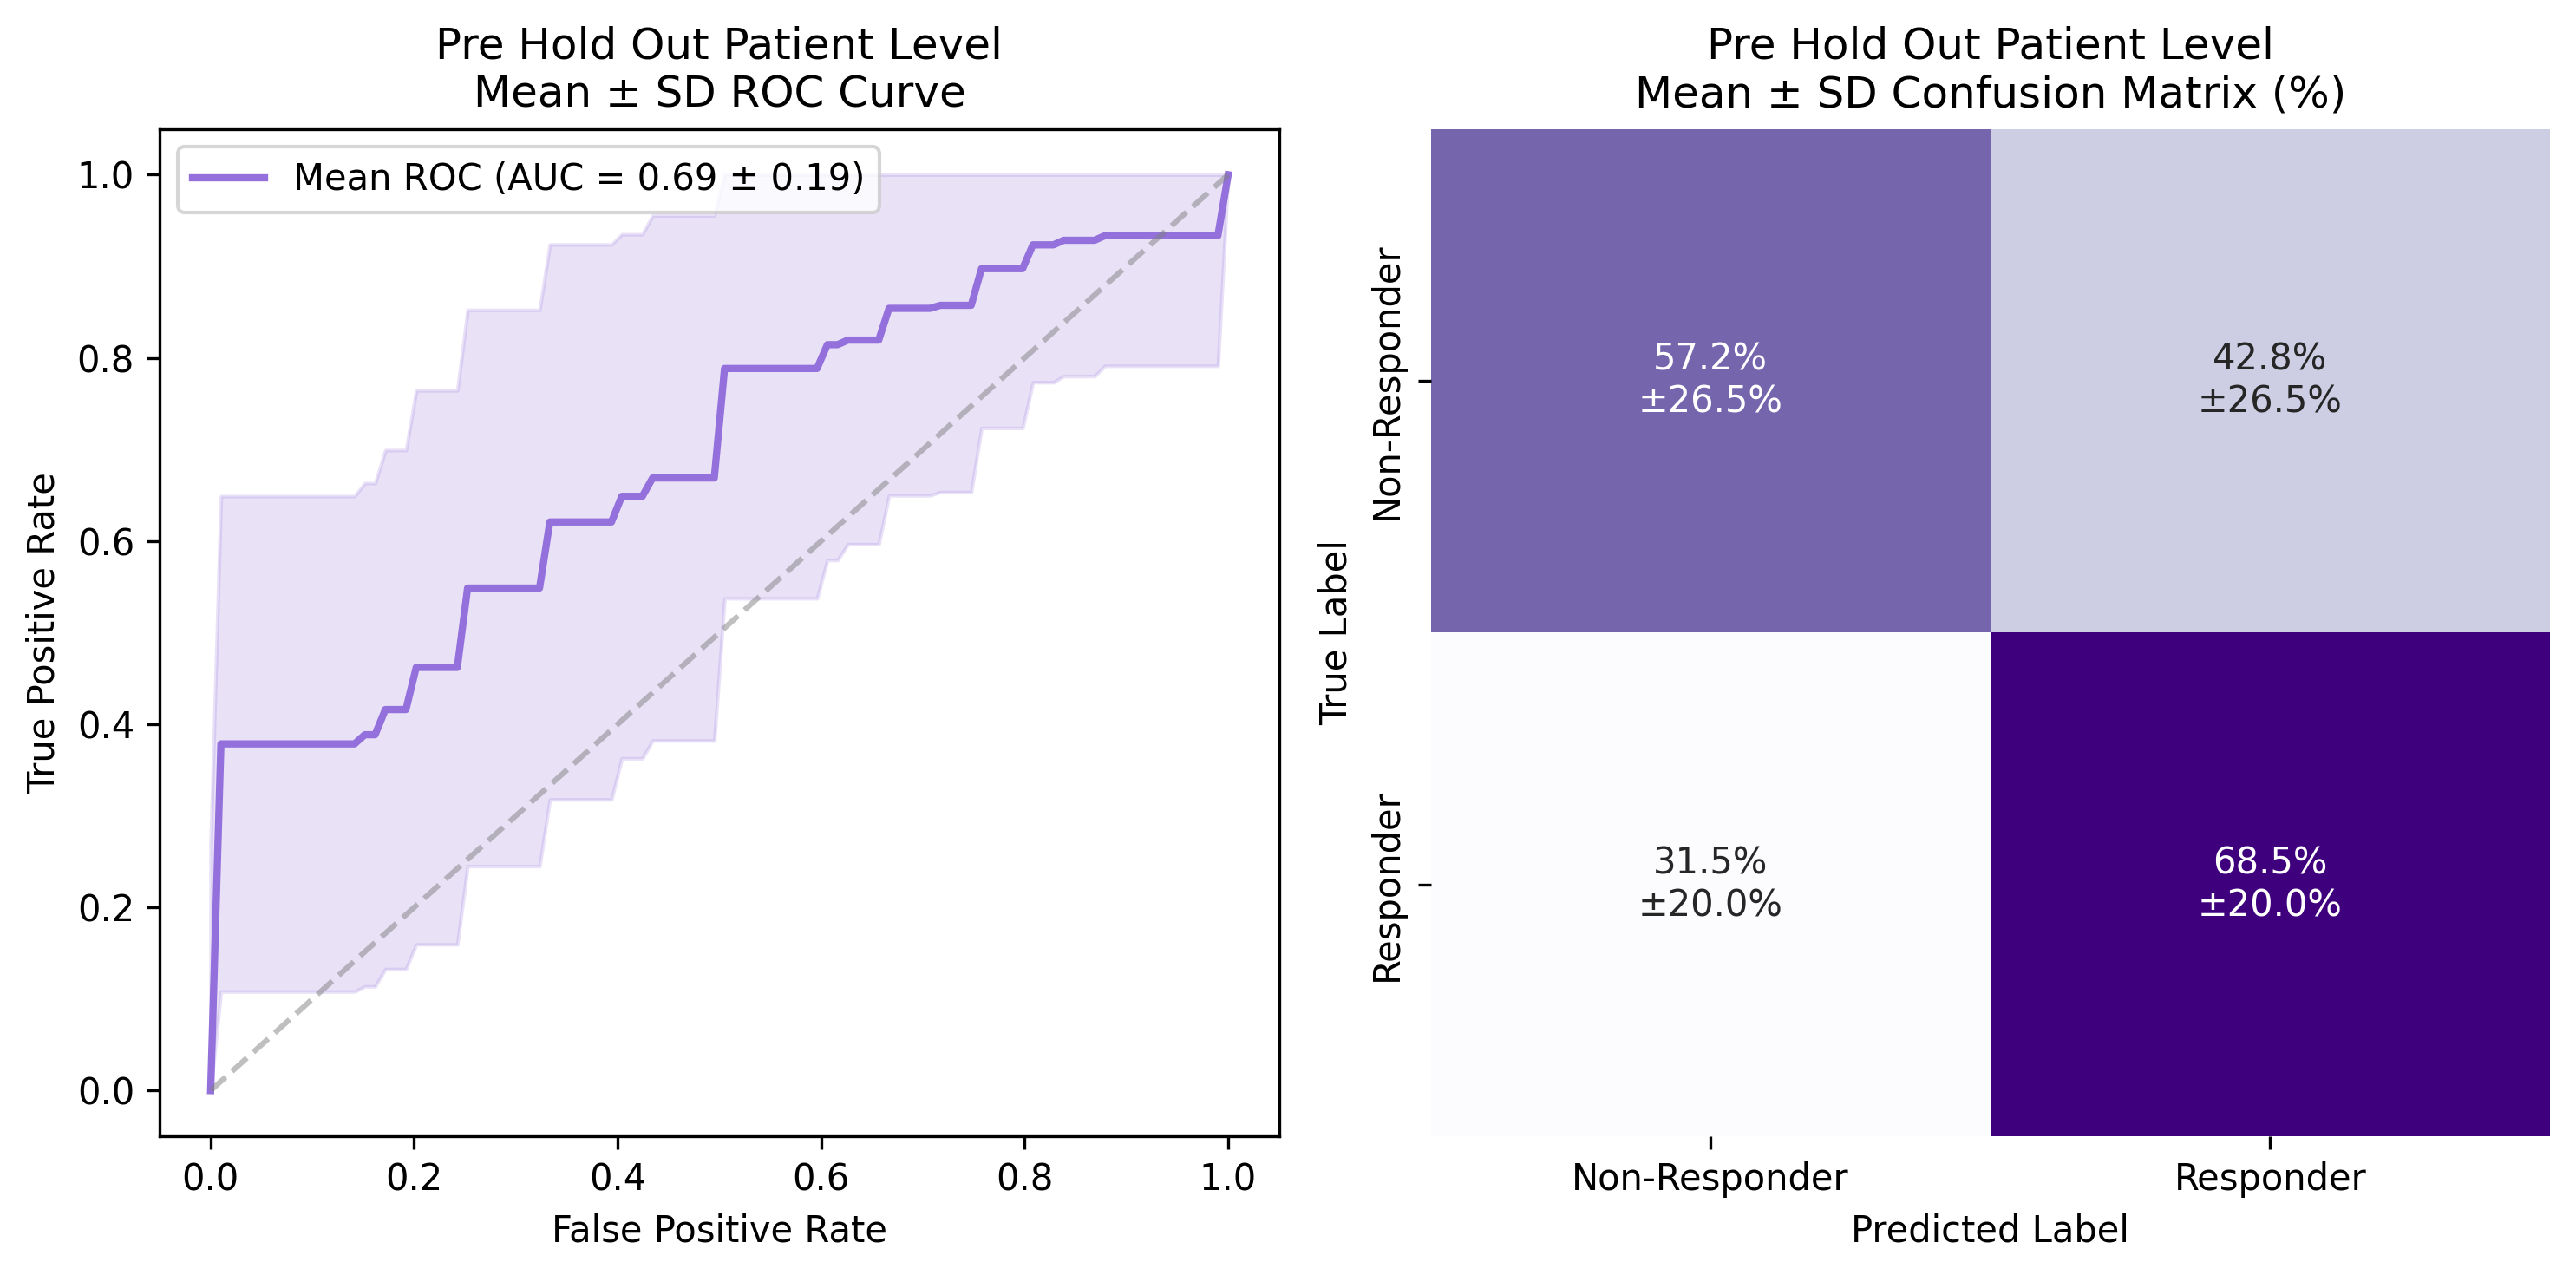

In [20]:
plot_metrics_by_glob(metrics, "MDS_Cross_Validation_*_Screen", "Cross Validation Screen")
plot_metrics_by_glob(metrics, "MDS_Cross_Validation_*_Day_0", "Cross Validation Day 0")
plot_metrics_by_glob(metrics, "MDS_Cross_Validation_*_Adj_Wk_1", "Cross Validation Adj Wk 1")
plot_metrics_by_glob(metrics, "MDS_Cross_Validation_*_Overall", "Cross Validation Overall")
plot_metrics_by_glob(metrics, "MDS_Cross_Validation_*_Patient", "Cross Validation Patient Level")

plot_metrics_by_glob(metrics, "MDS_Institute_Hold_Out_*_Screen", "Institute Hold Out Screen")
plot_metrics_by_glob(metrics, "MDS_Institute_Hold_Out_*_Day_0", "Institute Hold Out Day 0")
plot_metrics_by_glob(metrics, "MDS_Institute_Hold_Out_*_Adj_Wk_1", "Institute Hold Out Adj Wk 1")
plot_metrics_by_glob(metrics, "MDS_Institute_Hold_Out_*_Overall", "Institute Hold Out Overall")
plot_metrics_by_glob(metrics, "MDS_Institute_Hold_Out_*_Patient", "Institute Hold Out Patient Level")

plot_metrics_by_glob(metrics, "MDS_Pre_Hold_Out_*_Screen", "Pre Hold Out Screen")
plot_metrics_by_glob(metrics, "MDS_Pre_Hold_Out_*_Day_0", "Pre Hold Out Day 0")
plot_metrics_by_glob(metrics, "MDS_Pre_Hold_Out_*_Adj_Wk_1", "Pre Hold Out Adj Wk 1")
plot_metrics_by_glob(metrics, "MDS_Pre_Hold_Out_*_Overall", "Pre Hold Out Overall")
plot_metrics_by_glob(metrics, "MDS_Pre_Hold_Out_*_Patient", "Pre Hold Out Patient Level")